In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 2
num_attr_vals = 5
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 25 unqiue cards
Generated 300 cardpairs
-- 100 cardpairs with shared concept
-- 200 cardpairs without shared concept
[(0, 200), (1, 100)]
Total number of matches =  500
Number of shared concepts per match =  [(1, 500)]


## Data -- Distribution, Splits

In [3]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1e-100, 7000), (0.002, 500)]

In [5]:
np.sum(count_table)

500.0

In [6]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 9
xy_div_xyind_rank= 9


In [7]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

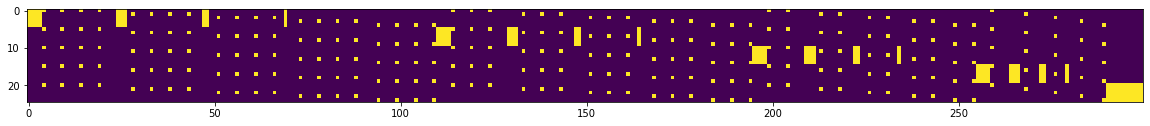

In [8]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

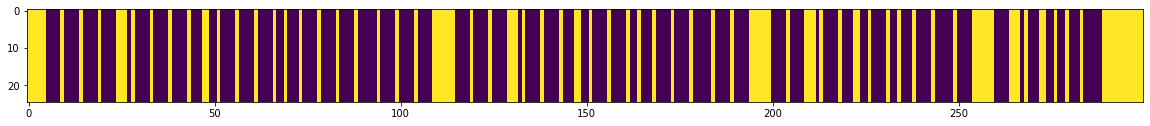

In [9]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

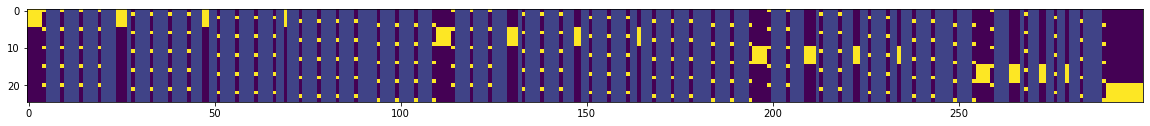

In [10]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

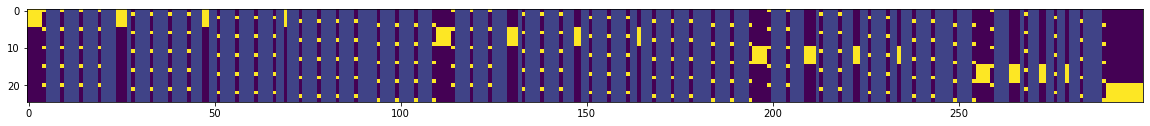

In [11]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [12]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(0.9999999999999997, 3800),
 (2.5e-97, 1920),
 (0.9999999999999993, 1000),
 (5.0, 380),
 (0.9999999999999998, 200),
 (4.999999999999999, 100),
 (2.5000000000000003e-97, 80),
 (5.000000000000001, 20)]

## Dataset

In [13]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('blue', 'dashed')
key
 0 ('red', 'void')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'checkered')
key
 0 ('red', 'void')
all matches 
 []


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]))

In [14]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('blue', 'dashed')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'checkered')
all matches 
 []


(7,
 tensor([7]),
 tensor([-54927409035608064]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]))

In [15]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [16]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [17]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [18]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            raise ValueError('Not supposed to use classifier!')
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [19]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [20]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [21]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [22]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 64,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':True,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K;dot-product'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 20.8 K
1  | model.inp_query_layer                        | Sequential         | 19.2 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 19.2 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 19.2 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 1.6 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 1.6 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 1.6 K 
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## Run Training

In [23]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=15000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-23-a09c12e82836>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():



   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 20.8 K
1  | model.inp_query_layer                        | Sequential         | 19.2 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 19.2 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 19.2 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 1.6 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 1.6 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 1.6 K 
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                     

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=1.6e+03, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 18.50it/s, loss=1.6e+03, v_num=k7zf]
                                                 

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 1:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=1.61e+03, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00, 17.28it/s, loss=1.63e+03, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=1.62e+03, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00, 18.24it/s, loss=1.6e+03, v_num=k7zf] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00, 20.19it/s, loss=1.58e+03, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00, 20.11it/s, loss=1.57e+03, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00, 20.18it/s, loss=1.56e+03, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00, 20.45it/s, loss=1.54e+03, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/2 [00:00<00:00, 19.04it/s, loss=1.53e+03, v_num=k7zf]
Validating: 0i

Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|█████     | 1/2 [00:00<00:00, 20.32it/s, loss=877, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|█████     | 1/2 [00:00<00:00, 19.65it/s, loss=858, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|█████     | 1/2 [00:00<00:00, 20.75it/s, loss=853, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 46:  50%|█████     | 1/2 [00:00<00:00, 20.04it/s, loss=840, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 47:  50%|█████     | 1/2 [00:00<00:00, 19.27it/s, loss=827, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 48:  50%|█████     | 1/2 [00:00<00:00, 19.88it/s, loss=809, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 14.83it/s, loss=801, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 50:  50%|█████     | 1/2 [00:00<00:00, 18.92it/s, loss=795, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 51:  50%|█████     | 1/2 [00:00<00:00, 20.07it/s, loss=781, v_num=k7zf]
Validating: 0it [00

Epoch 128:  50%|█████     | 1/2 [00:00<00:00, 22.88it/s, loss=477, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 129:  50%|█████     | 1/2 [00:00<00:00, 19.24it/s, loss=476, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 130:  50%|█████     | 1/2 [00:00<00:00, 20.97it/s, loss=474, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 131:  50%|█████     | 1/2 [00:00<00:00, 19.18it/s, loss=473, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 132:  50%|█████     | 1/2 [00:00<00:00, 19.26it/s, loss=472, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 133:  50%|█████     | 1/2 [00:00<00:00, 20.22it/s, loss=472, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 134:  50%|█████     | 1/2 [00:00<00:00, 20.30it/s, loss=469, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 135:  50%|█████     | 1/2 [00:00<00:00, 19.57it/s, loss=468, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 136:  50%|█████     | 1/2 [00:00<00:00, 18.71it/s, loss=466, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 137:

Epoch 213:  50%|█████     | 1/2 [00:00<00:00, 15.96it/s, loss=435, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 214:  50%|█████     | 1/2 [00:00<00:00, 19.97it/s, loss=435, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 215:  50%|█████     | 1/2 [00:00<00:00, 19.35it/s, loss=435, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 216:  50%|█████     | 1/2 [00:00<00:00, 19.80it/s, loss=435, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 217:  50%|█████     | 1/2 [00:00<00:00, 19.82it/s, loss=435, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 218:  50%|█████     | 1/2 [00:00<00:00, 19.57it/s, loss=435, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 219:  50%|█████     | 1/2 [00:00<00:00, 19.91it/s, loss=435, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 220:  50%|█████     | 1/2 [00:00<00:00, 15.57it/s, loss=435, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 221:  50%|█████     | 1/2 [00:00<00:00, 20.76it/s, loss=434, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 222:

Epoch 298:  50%|█████     | 1/2 [00:00<00:00, 19.25it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 299: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 300:  50%|█████     | 1/2 [00:00<00:00, 20.38it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 301:  50%|█████     | 1/2 [00:00<00:00, 20.66it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 302:  50%|█████     | 1/2 [00:00<00:00, 19.14it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 303:  50%|█████     | 1/2 [00:00<00:00, 18.92it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 304:  50%|█████     | 1/2 [00:00<00:00, 18.57it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 305:  50%|█████     | 1/2 [00:00<00:00, 21.22it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 306:  50%|█████     | 1/2 [00:00<00:00, 20.82it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 307:

Epoch 383:  50%|█████     | 1/2 [00:00<00:00, 17.36it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 384:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 385:  50%|█████     | 1/2 [00:00<00:00, 20.47it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 386:  50%|█████     | 1/2 [00:00<00:00, 19.85it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 387:  50%|█████     | 1/2 [00:00<00:00, 18.79it/s, loss=432, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 388:  50%|█████     | 1/2 [00:00<00:00, 21.09it/s, loss=432, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 389:  50%|█████     | 1/2 [00:00<00:00, 21.14it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 390:  50%|█████     | 1/2 [00:00<00:00, 20.69it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 391:  50%|█████     | 1/2 [00:00<00:00, 19.16it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 392:

Epoch 468:  50%|█████     | 1/2 [00:00<00:00, 19.52it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 469:  50%|█████     | 1/2 [00:00<00:00, 19.74it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 470:  50%|█████     | 1/2 [00:00<00:00, 19.98it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 471:  50%|█████     | 1/2 [00:00<00:00, 20.02it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 472:  50%|█████     | 1/2 [00:00<00:00, 19.21it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 473:  50%|█████     | 1/2 [00:00<00:00, 18.14it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 474:  50%|█████     | 1/2 [00:00<00:00, 20.00it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 475:  50%|█████     | 1/2 [00:00<00:00, 18.19it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 476:  50%|█████     | 1/2 [00:00<00:00, 20.94it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 477:

Epoch 553:  50%|█████     | 1/2 [00:00<00:00, 19.71it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 554:  50%|█████     | 1/2 [00:00<00:00, 19.70it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 555:  50%|█████     | 1/2 [00:00<00:00, 18.34it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 556:  50%|█████     | 1/2 [00:00<00:00, 21.13it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 557:  50%|█████     | 1/2 [00:00<00:00, 19.24it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 558:  50%|█████     | 1/2 [00:00<00:00, 19.81it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 559:  50%|█████     | 1/2 [00:00<00:00, 15.53it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 560:  50%|█████     | 1/2 [00:00<00:00, 19.00it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 561:  50%|█████     | 1/2 [00:00<00:00, 20.12it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 562:

Epoch 638:  50%|█████     | 1/2 [00:00<00:00, 21.18it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 639:  50%|█████     | 1/2 [00:00<00:00, 19.03it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 640:  50%|█████     | 1/2 [00:00<00:00, 16.98it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 641:  50%|█████     | 1/2 [00:00<00:00, 19.86it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 642:  50%|█████     | 1/2 [00:00<00:00, 20.18it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 643:  50%|█████     | 1/2 [00:00<00:00, 19.22it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 644:  50%|█████     | 1/2 [00:00<00:00, 19.46it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 645:  50%|█████     | 1/2 [00:00<00:00, 20.67it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 646:  50%|█████     | 1/2 [00:00<00:00, 19.36it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 647:

Epoch 723:  50%|█████     | 1/2 [00:00<00:00, 20.00it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 724:  50%|█████     | 1/2 [00:00<00:00, 17.31it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 725:  50%|█████     | 1/2 [00:00<00:00, 20.71it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 726:  50%|█████     | 1/2 [00:00<00:00, 20.01it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 727:  50%|█████     | 1/2 [00:00<00:00, 17.68it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 728:  50%|█████     | 1/2 [00:00<00:00, 21.39it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 729:  50%|█████     | 1/2 [00:00<00:00, 17.56it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 730:  50%|█████     | 1/2 [00:00<00:00, 19.92it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 731:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 732:

Epoch 808:  50%|█████     | 1/2 [00:00<00:00, 19.28it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 809:  50%|█████     | 1/2 [00:00<00:00, 17.18it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 810:  50%|█████     | 1/2 [00:00<00:00, 20.03it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 811:  50%|█████     | 1/2 [00:00<00:00, 22.05it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 812:  50%|█████     | 1/2 [00:00<00:00, 18.80it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 813:  50%|█████     | 1/2 [00:00<00:00, 19.92it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 814:  50%|█████     | 1/2 [00:00<00:00, 20.32it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 815:  50%|█████     | 1/2 [00:00<00:00, 20.36it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 816:  50%|█████     | 1/2 [00:00<00:00, 20.70it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 817:

Epoch 893:  50%|█████     | 1/2 [00:00<00:00, 17.67it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 894:  50%|█████     | 1/2 [00:00<00:00, 18.84it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 895:  50%|█████     | 1/2 [00:00<00:00, 19.94it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 896:  50%|█████     | 1/2 [00:00<00:00, 20.02it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 897:  50%|█████     | 1/2 [00:00<00:00, 21.68it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 898:  50%|█████     | 1/2 [00:00<00:00, 20.78it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 899: 100%|██████████| 2/2 [00:00<00:00, 14.43it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 900:  50%|█████     | 1/2 [00:00<00:00, 19.76it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 901:  50%|█████     | 1/2 [00:00<00:00, 20.99it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 902:

Epoch 978:  50%|█████     | 1/2 [00:00<00:00, 19.71it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 979:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 980:  50%|█████     | 1/2 [00:00<00:00, 22.06it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 981:  50%|█████     | 1/2 [00:00<00:00, 21.28it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 982:  50%|█████     | 1/2 [00:00<00:00, 21.05it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 983:  50%|█████     | 1/2 [00:00<00:00, 18.55it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 984:  50%|█████     | 1/2 [00:00<00:00, 21.29it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 985:  50%|█████     | 1/2 [00:00<00:00, 20.14it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 986:  50%|█████     | 1/2 [00:00<00:00, 20.16it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 987:

Epoch 1063:  50%|█████     | 1/2 [00:00<00:00, 20.21it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1064:  50%|█████     | 1/2 [00:00<00:00, 20.27it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1065:  50%|█████     | 1/2 [00:00<00:00, 19.77it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1066:  50%|█████     | 1/2 [00:00<00:00, 18.76it/s, loss=431, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1067:  50%|█████     | 1/2 [00:00<00:00, 19.21it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1068:  50%|█████     | 1/2 [00:00<00:00, 15.53it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1069:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1070:  50%|█████     | 1/2 [00:00<00:00, 20.69it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1071:  50%|█████     | 1/2 [00:00<00:00, 18.96it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1147:  50%|█████     | 1/2 [00:00<00:00, 18.55it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1148:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1149: 100%|██████████| 2/2 [00:00<00:00, 13.91it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1150:  50%|█████     | 1/2 [00:00<00:00, 21.15it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1151:  50%|█████     | 1/2 [00:00<00:00, 20.78it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1152:  50%|█████     | 1/2 [00:00<00:00, 16.39it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1153:  50%|█████     | 1/2 [00:00<00:00, 20.08it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1154:  50%|█████     | 1/2 [00:00<00:00, 21.34it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1155:  50%|█████     | 1/2 [00:00<00:00, 19.99it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1231:  50%|█████     | 1/2 [00:00<00:00, 19.60it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1232:  50%|█████     | 1/2 [00:00<00:00, 19.13it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1233:  50%|█████     | 1/2 [00:00<00:00, 19.87it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1234:  50%|█████     | 1/2 [00:00<00:00, 21.02it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1235:  50%|█████     | 1/2 [00:00<00:00, 19.76it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1236:  50%|█████     | 1/2 [00:00<00:00, 17.29it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1237:  50%|█████     | 1/2 [00:00<00:00, 18.85it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1238:  50%|█████     | 1/2 [00:00<00:00, 18.73it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1239:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1315:  50%|█████     | 1/2 [00:00<00:00, 19.43it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1316:  50%|█████     | 1/2 [00:00<00:00, 18.26it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1317:  50%|█████     | 1/2 [00:00<00:00, 20.94it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1318:  50%|█████     | 1/2 [00:00<00:00, 21.59it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1319:  50%|█████     | 1/2 [00:00<00:00, 20.21it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1320:  50%|█████     | 1/2 [00:00<00:00, 21.17it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1321:  50%|█████     | 1/2 [00:00<00:00, 19.82it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1322:  50%|█████     | 1/2 [00:00<00:00, 19.91it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1323:  50%|█████     | 1/2 [00:00<00:00, 20.63it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1399: 100%|██████████| 2/2 [00:00<00:00, 13.41it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1400:  50%|█████     | 1/2 [00:00<00:00, 20.11it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1401:  50%|█████     | 1/2 [00:00<00:00, 18.85it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1402:  50%|█████     | 1/2 [00:00<00:00, 19.34it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1403:  50%|█████     | 1/2 [00:00<00:00, 14.38it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1404:  50%|█████     | 1/2 [00:00<00:00, 19.24it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1405:  50%|█████     | 1/2 [00:00<00:00, 18.50it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1406:  50%|█████     | 1/2 [00:00<00:00, 20.19it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1407:  50%|█████     | 1/2 [00:00<00:00, 19.54it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1483:  50%|█████     | 1/2 [00:00<00:00, 20.63it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1484:  50%|█████     | 1/2 [00:00<00:00, 18.89it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1485:  50%|█████     | 1/2 [00:00<00:00, 20.49it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1486:  50%|█████     | 1/2 [00:00<00:00, 20.14it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1487:  50%|█████     | 1/2 [00:00<00:00, 20.10it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1488:  50%|█████     | 1/2 [00:00<00:00, 20.75it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1489:  50%|█████     | 1/2 [00:00<00:00, 20.68it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1490:  50%|█████     | 1/2 [00:00<00:00, 17.76it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1491:  50%|█████     | 1/2 [00:00<00:00, 19.69it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1567:  50%|█████     | 1/2 [00:00<00:00, 20.17it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1568:  50%|█████     | 1/2 [00:00<00:00, 19.61it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1569:  50%|█████     | 1/2 [00:00<00:00, 19.38it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1570:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1571:  50%|█████     | 1/2 [00:00<00:00, 19.00it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1572:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1573:  50%|█████     | 1/2 [00:00<00:00, 18.78it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1574:  50%|█████     | 1/2 [00:00<00:00, 19.48it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1575:  50%|█████     | 1/2 [00:00<00:00, 16.72it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1651:  50%|█████     | 1/2 [00:00<00:00, 22.85it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1652:  50%|█████     | 1/2 [00:00<00:00, 20.34it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1653:  50%|█████     | 1/2 [00:00<00:00, 19.28it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1654:  50%|█████     | 1/2 [00:00<00:00, 19.01it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1655:  50%|█████     | 1/2 [00:00<00:00, 20.19it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1656:  50%|█████     | 1/2 [00:00<00:00, 19.56it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1657:  50%|█████     | 1/2 [00:00<00:00, 20.71it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1658:  50%|█████     | 1/2 [00:00<00:00, 20.52it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1659:  50%|█████     | 1/2 [00:00<00:00, 19.09it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1735:  50%|█████     | 1/2 [00:00<00:00, 20.40it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1736:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1737:  50%|█████     | 1/2 [00:00<00:00, 21.40it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1738:  50%|█████     | 1/2 [00:00<00:00, 19.78it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1739:  50%|█████     | 1/2 [00:00<00:00, 19.09it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1740:  50%|█████     | 1/2 [00:00<00:00, 19.07it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1741:  50%|█████     | 1/2 [00:00<00:00, 21.38it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1742:  50%|█████     | 1/2 [00:00<00:00, 20.64it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1743:  50%|█████     | 1/2 [00:00<00:00, 19.62it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1819:  50%|█████     | 1/2 [00:00<00:00, 22.11it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1820:  50%|█████     | 1/2 [00:00<00:00, 18.82it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1821:  50%|█████     | 1/2 [00:00<00:00, 19.01it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1822:  50%|█████     | 1/2 [00:00<00:00, 17.98it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1823:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1824:  50%|█████     | 1/2 [00:00<00:00, 19.28it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1825:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1826:  50%|█████     | 1/2 [00:00<00:00, 22.03it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1827:  50%|█████     | 1/2 [00:00<00:00, 20.06it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1903:  50%|█████     | 1/2 [00:00<00:00, 20.77it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1904:  50%|█████     | 1/2 [00:00<00:00, 19.22it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1905:  50%|█████     | 1/2 [00:00<00:00, 18.36it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1906:  50%|█████     | 1/2 [00:00<00:00, 20.35it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1907:  50%|█████     | 1/2 [00:00<00:00, 18.90it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1908:  50%|█████     | 1/2 [00:00<00:00, 21.16it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1909:  50%|█████     | 1/2 [00:00<00:00, 17.70it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1910:  50%|█████     | 1/2 [00:00<00:00, 19.66it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1911:  50%|█████     | 1/2 [00:00<00:00, 18.28it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1987:  50%|█████     | 1/2 [00:00<00:00, 20.12it/s, loss=430, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1988:  50%|█████     | 1/2 [00:00<00:00, 20.24it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1989:  50%|█████     | 1/2 [00:00<00:00, 19.38it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1990:  50%|█████     | 1/2 [00:00<00:00, 18.78it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1991:  50%|█████     | 1/2 [00:00<00:00, 20.26it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1992:  50%|█████     | 1/2 [00:00<00:00, 19.11it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1993:  50%|█████     | 1/2 [00:00<00:00, 20.99it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1994:  50%|█████     | 1/2 [00:00<00:00, 20.74it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 1995:  50%|█████     | 1/2 [00:00<00:00, 19.59it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2071:  50%|█████     | 1/2 [00:00<00:00, 18.87it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2072:  50%|█████     | 1/2 [00:00<00:00, 20.32it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2073:  50%|█████     | 1/2 [00:00<00:00, 19.14it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2074:  50%|█████     | 1/2 [00:00<00:00, 16.60it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2075:  50%|█████     | 1/2 [00:00<00:00, 19.36it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2076:  50%|█████     | 1/2 [00:00<00:00, 19.95it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2077:  50%|█████     | 1/2 [00:00<00:00, 19.89it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2078:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2079:  50%|█████     | 1/2 [00:00<00:00, 19.27it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2155:  50%|█████     | 1/2 [00:00<00:00, 20.60it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2156:  50%|█████     | 1/2 [00:00<00:00, 19.01it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2157:  50%|█████     | 1/2 [00:00<00:00, 19.09it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2158:  50%|█████     | 1/2 [00:00<00:00, 21.03it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2159:  50%|█████     | 1/2 [00:00<00:00, 21.82it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2160:  50%|█████     | 1/2 [00:00<00:00, 19.02it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2161:  50%|█████     | 1/2 [00:00<00:00, 20.23it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2162:  50%|█████     | 1/2 [00:00<00:00, 19.10it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2163:  50%|█████     | 1/2 [00:00<00:00, 20.59it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2239:  50%|█████     | 1/2 [00:00<00:00, 19.44it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2240:  50%|█████     | 1/2 [00:00<00:00, 17.99it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2241:  50%|█████     | 1/2 [00:00<00:00, 19.15it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2242:  50%|█████     | 1/2 [00:00<00:00, 19.01it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2243:  50%|█████     | 1/2 [00:00<00:00, 20.74it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2244:  50%|█████     | 1/2 [00:00<00:00, 19.53it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2245:  50%|█████     | 1/2 [00:00<00:00, 17.43it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2246:  50%|█████     | 1/2 [00:00<00:00, 21.13it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2247:  50%|█████     | 1/2 [00:00<00:00, 19.73it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2323:  50%|█████     | 1/2 [00:00<00:00, 18.90it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2324:  50%|█████     | 1/2 [00:00<00:00, 21.73it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2325:  50%|█████     | 1/2 [00:00<00:00, 22.02it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2326:  50%|█████     | 1/2 [00:00<00:00, 20.36it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2327:  50%|█████     | 1/2 [00:00<00:00, 20.66it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2328:  50%|█████     | 1/2 [00:00<00:00, 19.95it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2329:  50%|█████     | 1/2 [00:00<00:00, 19.44it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2330:  50%|█████     | 1/2 [00:00<00:00, 19.33it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2331:  50%|█████     | 1/2 [00:00<00:00, 21.05it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2407:  50%|█████     | 1/2 [00:00<00:00, 20.22it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2408:  50%|█████     | 1/2 [00:00<00:00, 20.32it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2409:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2410:  50%|█████     | 1/2 [00:00<00:00, 18.99it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2411:  50%|█████     | 1/2 [00:00<00:00, 19.09it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2412:  50%|█████     | 1/2 [00:00<00:00, 19.88it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2413:  50%|█████     | 1/2 [00:00<00:00, 19.31it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2414:  50%|█████     | 1/2 [00:00<00:00, 16.64it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2415:  50%|█████     | 1/2 [00:00<00:00, 19.37it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2491:  50%|█████     | 1/2 [00:00<00:00, 20.01it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2492:  50%|█████     | 1/2 [00:00<00:00, 19.79it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2493:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2494:  50%|█████     | 1/2 [00:00<00:00, 20.25it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2495:  50%|█████     | 1/2 [00:00<00:00, 21.84it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2496:  50%|█████     | 1/2 [00:00<00:00, 21.57it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2497:  50%|█████     | 1/2 [00:00<00:00, 21.12it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2498:  50%|█████     | 1/2 [00:00<00:00, 19.91it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2499: 100%|██████████| 2/2 [00:00<00:00, 13.18it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2575:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2576:  50%|█████     | 1/2 [00:00<00:00, 19.00it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2577:  50%|█████     | 1/2 [00:00<00:00, 19.83it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2578:  50%|█████     | 1/2 [00:00<00:00, 15.87it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2579:  50%|█████     | 1/2 [00:00<00:00, 20.00it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2580:  50%|█████     | 1/2 [00:00<00:00, 19.38it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2581:  50%|█████     | 1/2 [00:00<00:00, 20.50it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2582:  50%|█████     | 1/2 [00:00<00:00, 20.68it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2583:  50%|█████     | 1/2 [00:00<00:00, 19.92it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2659:  50%|█████     | 1/2 [00:00<00:00, 19.55it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2660:  50%|█████     | 1/2 [00:00<00:00, 20.22it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2661:  50%|█████     | 1/2 [00:00<00:00, 22.60it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2662:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2663:  50%|█████     | 1/2 [00:00<00:00, 19.37it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2664:  50%|█████     | 1/2 [00:00<00:00, 18.86it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2665:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2666:  50%|█████     | 1/2 [00:00<00:00, 17.23it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2667:  50%|█████     | 1/2 [00:00<00:00, 17.47it/s, loss=429, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2743:  50%|█████     | 1/2 [00:00<00:00, 19.86it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2744:  50%|█████     | 1/2 [00:00<00:00, 19.86it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2745:  50%|█████     | 1/2 [00:00<00:00, 20.94it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2746:  50%|█████     | 1/2 [00:00<00:00, 19.26it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2747:  50%|█████     | 1/2 [00:00<00:00, 19.56it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2748:  50%|█████     | 1/2 [00:00<00:00, 20.06it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2749: 100%|██████████| 2/2 [00:00<00:00, 13.82it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2750:  50%|█████     | 1/2 [00:00<00:00, 20.61it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2751:  50%|█████     | 1/2 [00:00<00:00, 20.71it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2827:  50%|█████     | 1/2 [00:00<00:00, 20.24it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2828:  50%|█████     | 1/2 [00:00<00:00, 20.78it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2829:  50%|█████     | 1/2 [00:00<00:00, 19.76it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2830:  50%|█████     | 1/2 [00:00<00:00, 19.36it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2831:  50%|█████     | 1/2 [00:00<00:00, 21.29it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2832:  50%|█████     | 1/2 [00:00<00:00, 19.34it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2833:  50%|█████     | 1/2 [00:00<00:00, 19.21it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2834:  50%|█████     | 1/2 [00:00<00:00, 21.02it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2835:  50%|█████     | 1/2 [00:00<00:00, 18.86it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2911:  50%|█████     | 1/2 [00:00<00:00, 21.63it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2912:  50%|█████     | 1/2 [00:00<00:00, 20.11it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2913:  50%|█████     | 1/2 [00:00<00:00, 20.38it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2914:  50%|█████     | 1/2 [00:00<00:00, 20.95it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2915:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2916:  50%|█████     | 1/2 [00:00<00:00, 20.35it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2917:  50%|█████     | 1/2 [00:00<00:00, 19.51it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2918:  50%|█████     | 1/2 [00:00<00:00, 19.69it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2919:  50%|█████     | 1/2 [00:00<00:00, 21.34it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2995:  50%|█████     | 1/2 [00:00<00:00, 20.49it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2996:  50%|█████     | 1/2 [00:00<00:00, 17.38it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2997:  50%|█████     | 1/2 [00:00<00:00, 20.64it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2998:  50%|█████     | 1/2 [00:00<00:00, 19.53it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 2999: 100%|██████████| 2/2 [00:00<00:00, 14.18it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3000:  50%|█████     | 1/2 [00:00<00:00, 20.84it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3001:  50%|█████     | 1/2 [00:00<00:00, 20.36it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3002:  50%|█████     | 1/2 [00:00<00:00, 20.48it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3003:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3079:  50%|█████     | 1/2 [00:00<00:00, 19.50it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3080:  50%|█████     | 1/2 [00:00<00:00, 20.68it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3081:  50%|█████     | 1/2 [00:00<00:00, 19.92it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3082:  50%|█████     | 1/2 [00:00<00:00, 20.43it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3083:  50%|█████     | 1/2 [00:00<00:00, 20.64it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3084:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3085:  50%|█████     | 1/2 [00:00<00:00, 19.21it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3086:  50%|█████     | 1/2 [00:00<00:00, 16.94it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3087:  50%|█████     | 1/2 [00:00<00:00, 19.16it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3163:  50%|█████     | 1/2 [00:00<00:00, 18.01it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3164:  50%|█████     | 1/2 [00:00<00:00, 19.86it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3165:  50%|█████     | 1/2 [00:00<00:00, 20.23it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3166:  50%|█████     | 1/2 [00:00<00:00, 19.55it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3167:  50%|█████     | 1/2 [00:00<00:00, 21.16it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3168:  50%|█████     | 1/2 [00:00<00:00, 20.57it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3169:  50%|█████     | 1/2 [00:00<00:00, 21.21it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3170:  50%|█████     | 1/2 [00:00<00:00, 18.27it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3171:  50%|█████     | 1/2 [00:00<00:00, 13.91it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3247:  50%|█████     | 1/2 [00:00<00:00, 19.01it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3248:  50%|█████     | 1/2 [00:00<00:00, 20.11it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3249: 100%|██████████| 2/2 [00:00<00:00, 13.55it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3250:  50%|█████     | 1/2 [00:00<00:00, 22.80it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3251:  50%|█████     | 1/2 [00:00<00:00, 20.02it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3252:  50%|█████     | 1/2 [00:00<00:00, 18.96it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3253:  50%|█████     | 1/2 [00:00<00:00, 20.23it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3254:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3255:  50%|█████     | 1/2 [00:00<00:00, 19.74it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3331:  50%|█████     | 1/2 [00:00<00:00, 19.62it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3332:  50%|█████     | 1/2 [00:00<00:00, 21.08it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3333:  50%|█████     | 1/2 [00:00<00:00, 18.27it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3334:  50%|█████     | 1/2 [00:00<00:00, 18.74it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3335:  50%|█████     | 1/2 [00:00<00:00, 21.52it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3336:  50%|█████     | 1/2 [00:00<00:00, 19.62it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3337:  50%|█████     | 1/2 [00:00<00:00, 18.35it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3338:  50%|█████     | 1/2 [00:00<00:00, 19.86it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3339:  50%|█████     | 1/2 [00:00<00:00, 17.82it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3415:  50%|█████     | 1/2 [00:00<00:00, 19.72it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3416:  50%|█████     | 1/2 [00:00<00:00, 20.52it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3417:  50%|█████     | 1/2 [00:00<00:00, 19.14it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3418:  50%|█████     | 1/2 [00:00<00:00, 21.46it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3419:  50%|█████     | 1/2 [00:00<00:00, 20.50it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3420:  50%|█████     | 1/2 [00:00<00:00, 21.70it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3421:  50%|█████     | 1/2 [00:00<00:00, 19.49it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3422:  50%|█████     | 1/2 [00:00<00:00, 20.60it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3423:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3499: 100%|██████████| 2/2 [00:00<00:00, 14.45it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3500:  50%|█████     | 1/2 [00:00<00:00, 18.85it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3501:  50%|█████     | 1/2 [00:00<00:00, 19.15it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3502:  50%|█████     | 1/2 [00:00<00:00, 20.90it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3503:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3504:  50%|█████     | 1/2 [00:00<00:00, 20.27it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3505:  50%|█████     | 1/2 [00:00<00:00, 19.92it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3506:  50%|█████     | 1/2 [00:00<00:00, 19.26it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3507:  50%|█████     | 1/2 [00:00<00:00, 19.99it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3583:  50%|█████     | 1/2 [00:00<00:00, 18.85it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3584:  50%|█████     | 1/2 [00:00<00:00, 19.52it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3585:  50%|█████     | 1/2 [00:00<00:00, 21.03it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3586:  50%|█████     | 1/2 [00:00<00:00, 20.62it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3587:  50%|█████     | 1/2 [00:00<00:00, 19.04it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3588:  50%|█████     | 1/2 [00:00<00:00, 19.10it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3589:  50%|█████     | 1/2 [00:00<00:00, 21.48it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3590:  50%|█████     | 1/2 [00:00<00:00, 19.47it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3591:  50%|█████     | 1/2 [00:00<00:00, 19.01it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3667:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3668:  50%|█████     | 1/2 [00:00<00:00, 19.31it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3669:  50%|█████     | 1/2 [00:00<00:00, 16.94it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3670:  50%|█████     | 1/2 [00:00<00:00, 21.34it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3671:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3672:  50%|█████     | 1/2 [00:00<00:00, 18.12it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3673:  50%|█████     | 1/2 [00:00<00:00, 20.98it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3674:  50%|█████     | 1/2 [00:00<00:00, 19.19it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3675:  50%|█████     | 1/2 [00:00<00:00, 21.24it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3751:  50%|█████     | 1/2 [00:00<00:00, 19.28it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3752:  50%|█████     | 1/2 [00:00<00:00, 21.24it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3753:  50%|█████     | 1/2 [00:00<00:00, 21.38it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3754:  50%|█████     | 1/2 [00:00<00:00, 20.02it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3755:  50%|█████     | 1/2 [00:00<00:00, 19.47it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3756:  50%|█████     | 1/2 [00:00<00:00, 19.94it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3757:  50%|█████     | 1/2 [00:00<00:00, 20.31it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3758:  50%|█████     | 1/2 [00:00<00:00, 19.99it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3759:  50%|█████     | 1/2 [00:00<00:00, 20.24it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3835:  50%|█████     | 1/2 [00:00<00:00, 18.76it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3836:  50%|█████     | 1/2 [00:00<00:00, 21.32it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3837:  50%|█████     | 1/2 [00:00<00:00, 20.87it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3838:  50%|█████     | 1/2 [00:00<00:00, 19.83it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3839:  50%|█████     | 1/2 [00:00<00:00, 18.71it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3840:  50%|█████     | 1/2 [00:00<00:00, 20.82it/s, loss=428, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3841:  50%|█████     | 1/2 [00:00<00:00, 19.16it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3842:  50%|█████     | 1/2 [00:00<00:00, 22.23it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3843:  50%|█████     | 1/2 [00:00<00:00, 19.64it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3919:  50%|█████     | 1/2 [00:00<00:00, 22.21it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3920:  50%|█████     | 1/2 [00:00<00:00, 20.42it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3921:  50%|█████     | 1/2 [00:00<00:00, 17.74it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3922:  50%|█████     | 1/2 [00:00<00:00, 20.49it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3923:  50%|█████     | 1/2 [00:00<00:00, 19.04it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3924:  50%|█████     | 1/2 [00:00<00:00, 19.90it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3925:  50%|█████     | 1/2 [00:00<00:00, 20.51it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3926:  50%|█████     | 1/2 [00:00<00:00, 19.04it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 3927:  50%|█████     | 1/2 [00:00<00:00, 19.88it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4003:  50%|█████     | 1/2 [00:00<00:00, 17.79it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4004:  50%|█████     | 1/2 [00:00<00:00, 20.14it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4005:  50%|█████     | 1/2 [00:00<00:00, 20.60it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4006:  50%|█████     | 1/2 [00:00<00:00, 19.67it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4007:  50%|█████     | 1/2 [00:00<00:00, 21.40it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4008:  50%|█████     | 1/2 [00:00<00:00, 18.76it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4009:  50%|█████     | 1/2 [00:00<00:00, 19.60it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4010:  50%|█████     | 1/2 [00:00<00:00, 20.49it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4011:  50%|█████     | 1/2 [00:00<00:00, 19.62it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4087:  50%|█████     | 1/2 [00:00<00:00, 18.43it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4088:  50%|█████     | 1/2 [00:00<00:00, 19.80it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4089:  50%|█████     | 1/2 [00:00<00:00, 18.92it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4090:  50%|█████     | 1/2 [00:00<00:00, 19.65it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4091:  50%|█████     | 1/2 [00:00<00:00, 18.92it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4092:  50%|█████     | 1/2 [00:00<00:00, 20.09it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4093:  50%|█████     | 1/2 [00:00<00:00, 19.49it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4094:  50%|█████     | 1/2 [00:00<00:00, 20.37it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4095:  50%|█████     | 1/2 [00:00<00:00, 18.47it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4171:  50%|█████     | 1/2 [00:00<00:00, 20.13it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4172:  50%|█████     | 1/2 [00:00<00:00, 18.14it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4173:  50%|█████     | 1/2 [00:00<00:00, 20.52it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4174:  50%|█████     | 1/2 [00:00<00:00, 20.77it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4175:  50%|█████     | 1/2 [00:00<00:00, 19.52it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4176:  50%|█████     | 1/2 [00:00<00:00, 20.09it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4177:  50%|█████     | 1/2 [00:00<00:00, 20.72it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4178:  50%|█████     | 1/2 [00:00<00:00, 17.33it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4179:  50%|█████     | 1/2 [00:00<00:00, 20.36it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4255:  50%|█████     | 1/2 [00:00<00:00, 20.23it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4256:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4257:  50%|█████     | 1/2 [00:00<00:00, 20.71it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4258:  50%|█████     | 1/2 [00:00<00:00, 19.77it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4259:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4260:  50%|█████     | 1/2 [00:00<00:00, 17.14it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4261:  50%|█████     | 1/2 [00:00<00:00, 18.84it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4262:  50%|█████     | 1/2 [00:00<00:00, 22.08it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4263:  50%|█████     | 1/2 [00:00<00:00, 21.02it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4339:  50%|█████     | 1/2 [00:00<00:00, 21.00it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4340:  50%|█████     | 1/2 [00:00<00:00, 19.74it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4341:  50%|█████     | 1/2 [00:00<00:00, 20.16it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4342:  50%|█████     | 1/2 [00:00<00:00, 19.24it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4343:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4344:  50%|█████     | 1/2 [00:00<00:00, 19.15it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4345:  50%|█████     | 1/2 [00:00<00:00, 19.89it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4346:  50%|█████     | 1/2 [00:00<00:00, 19.00it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4347:  50%|█████     | 1/2 [00:00<00:00, 21.87it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4423:  50%|█████     | 1/2 [00:00<00:00, 18.67it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4424:  50%|█████     | 1/2 [00:00<00:00, 19.46it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4425:  50%|█████     | 1/2 [00:00<00:00, 19.66it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4426:  50%|█████     | 1/2 [00:00<00:00, 16.44it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4427:  50%|█████     | 1/2 [00:00<00:00, 19.69it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4428:  50%|█████     | 1/2 [00:00<00:00, 20.68it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4429:  50%|█████     | 1/2 [00:00<00:00, 17.44it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4430:  50%|█████     | 1/2 [00:00<00:00, 16.35it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4431:  50%|█████     | 1/2 [00:00<00:00, 19.83it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4507:  50%|█████     | 1/2 [00:00<00:00, 20.60it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4508:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4509:  50%|█████     | 1/2 [00:00<00:00, 19.54it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4510:  50%|█████     | 1/2 [00:00<00:00, 21.16it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4511:  50%|█████     | 1/2 [00:00<00:00, 20.28it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4512:  50%|█████     | 1/2 [00:00<00:00, 19.68it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4513:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4514:  50%|█████     | 1/2 [00:00<00:00, 17.99it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4515:  50%|█████     | 1/2 [00:00<00:00, 20.06it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4591:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4592:  50%|█████     | 1/2 [00:00<00:00, 20.85it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4593:  50%|█████     | 1/2 [00:00<00:00, 21.15it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4594:  50%|█████     | 1/2 [00:00<00:00, 20.24it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4595:  50%|█████     | 1/2 [00:00<00:00, 20.16it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4596:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4597:  50%|█████     | 1/2 [00:00<00:00, 19.67it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4598:  50%|█████     | 1/2 [00:00<00:00, 19.52it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4599: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4675:  50%|█████     | 1/2 [00:00<00:00, 16.77it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4676:  50%|█████     | 1/2 [00:00<00:00, 19.42it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4677:  50%|█████     | 1/2 [00:00<00:00, 20.83it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4678:  50%|█████     | 1/2 [00:00<00:00, 20.22it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4679:  50%|█████     | 1/2 [00:00<00:00, 19.43it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4680:  50%|█████     | 1/2 [00:00<00:00, 19.40it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4681:  50%|█████     | 1/2 [00:00<00:00, 19.71it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4682:  50%|█████     | 1/2 [00:00<00:00, 20.23it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4683:  50%|█████     | 1/2 [00:00<00:00, 17.44it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4759:  50%|█████     | 1/2 [00:00<00:00, 20.08it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4760:  50%|█████     | 1/2 [00:00<00:00, 17.83it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4761:  50%|█████     | 1/2 [00:00<00:00, 21.11it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4762:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4763:  50%|█████     | 1/2 [00:00<00:00, 19.68it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4764:  50%|█████     | 1/2 [00:00<00:00, 20.50it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4765:  50%|█████     | 1/2 [00:00<00:00, 21.04it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4766:  50%|█████     | 1/2 [00:00<00:00, 19.91it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4767:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4843:  50%|█████     | 1/2 [00:00<00:00, 19.64it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4844:  50%|█████     | 1/2 [00:00<00:00, 19.48it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4845:  50%|█████     | 1/2 [00:00<00:00, 19.23it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4846:  50%|█████     | 1/2 [00:00<00:00, 20.75it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4847:  50%|█████     | 1/2 [00:00<00:00, 20.84it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4848:  50%|█████     | 1/2 [00:00<00:00, 19.85it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4849: 100%|██████████| 2/2 [00:00<00:00, 13.41it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4850:  50%|█████     | 1/2 [00:00<00:00, 19.47it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4851:  50%|█████     | 1/2 [00:00<00:00, 19.94it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4927:  50%|█████     | 1/2 [00:00<00:00, 20.20it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4928:  50%|█████     | 1/2 [00:00<00:00, 20.81it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4929:  50%|█████     | 1/2 [00:00<00:00, 19.27it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4930:  50%|█████     | 1/2 [00:00<00:00, 20.64it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4931:  50%|█████     | 1/2 [00:00<00:00, 20.63it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4932:  50%|█████     | 1/2 [00:00<00:00, 17.06it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4933:  50%|█████     | 1/2 [00:00<00:00, 21.09it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4934:  50%|█████     | 1/2 [00:00<00:00, 17.89it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 4935:  50%|█████     | 1/2 [00:00<00:00, 19.63it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5011:  50%|█████     | 1/2 [00:00<00:00, 18.08it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5012:  50%|█████     | 1/2 [00:00<00:00, 20.65it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5013:  50%|█████     | 1/2 [00:00<00:00, 20.90it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5014:  50%|█████     | 1/2 [00:00<00:00, 19.06it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5015:  50%|█████     | 1/2 [00:00<00:00, 21.39it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5016:  50%|█████     | 1/2 [00:00<00:00, 21.33it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5017:  50%|█████     | 1/2 [00:00<00:00, 17.02it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5018:  50%|█████     | 1/2 [00:00<00:00, 21.16it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5019:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5095:  50%|█████     | 1/2 [00:00<00:00, 21.04it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5096:  50%|█████     | 1/2 [00:00<00:00, 20.85it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5097:  50%|█████     | 1/2 [00:00<00:00, 14.07it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5098:  50%|█████     | 1/2 [00:00<00:00, 18.73it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5099: 100%|██████████| 2/2 [00:00<00:00, 14.27it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5100:  50%|█████     | 1/2 [00:00<00:00, 20.11it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5101:  50%|█████     | 1/2 [00:00<00:00, 16.86it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5102:  50%|█████     | 1/2 [00:00<00:00, 19.81it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5103:  50%|█████     | 1/2 [00:00<00:00, 19.95it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5179:  50%|█████     | 1/2 [00:00<00:00, 19.61it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5180:  50%|█████     | 1/2 [00:00<00:00, 19.09it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5181:  50%|█████     | 1/2 [00:00<00:00, 19.67it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5182:  50%|█████     | 1/2 [00:00<00:00, 19.89it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5183:  50%|█████     | 1/2 [00:00<00:00, 19.63it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5184:  50%|█████     | 1/2 [00:00<00:00, 17.22it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5185:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5186:  50%|█████     | 1/2 [00:00<00:00, 19.47it/s, loss=427, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5187:  50%|█████     | 1/2 [00:00<00:00, 19.40it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5263:  50%|█████     | 1/2 [00:00<00:00, 19.13it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5264:  50%|█████     | 1/2 [00:00<00:00, 21.96it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5265:  50%|█████     | 1/2 [00:00<00:00, 19.12it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5266:  50%|█████     | 1/2 [00:00<00:00, 20.31it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5267:  50%|█████     | 1/2 [00:00<00:00, 18.92it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5268:  50%|█████     | 1/2 [00:00<00:00, 19.57it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5269:  50%|█████     | 1/2 [00:00<00:00, 20.24it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5270:  50%|█████     | 1/2 [00:00<00:00, 20.95it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5271:  50%|█████     | 1/2 [00:00<00:00, 19.47it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5347:  50%|█████     | 1/2 [00:00<00:00, 18.24it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5348:  50%|█████     | 1/2 [00:00<00:00, 20.73it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5349: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5350:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5351:  50%|█████     | 1/2 [00:00<00:00, 19.35it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5352:  50%|█████     | 1/2 [00:00<00:00, 18.78it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5353:  50%|█████     | 1/2 [00:00<00:00, 18.51it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5354:  50%|█████     | 1/2 [00:00<00:00, 19.78it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5355:  50%|█████     | 1/2 [00:00<00:00, 20.04it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5431:  50%|█████     | 1/2 [00:00<00:00, 20.92it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5432:  50%|█████     | 1/2 [00:00<00:00, 20.52it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5433:  50%|█████     | 1/2 [00:00<00:00, 20.81it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5434:  50%|█████     | 1/2 [00:00<00:00, 22.11it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5435:  50%|█████     | 1/2 [00:00<00:00, 22.53it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5436:  50%|█████     | 1/2 [00:00<00:00, 20.67it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5437:  50%|█████     | 1/2 [00:00<00:00, 19.53it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5438:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5439:  50%|█████     | 1/2 [00:00<00:00, 19.07it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5515:  50%|█████     | 1/2 [00:00<00:00, 19.68it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5516:  50%|█████     | 1/2 [00:00<00:00, 19.64it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5517:  50%|█████     | 1/2 [00:00<00:00, 18.56it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5518:  50%|█████     | 1/2 [00:00<00:00, 17.78it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5519:  50%|█████     | 1/2 [00:00<00:00, 20.04it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5520:  50%|█████     | 1/2 [00:00<00:00, 20.33it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5521:  50%|█████     | 1/2 [00:00<00:00, 21.04it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5522:  50%|█████     | 1/2 [00:00<00:00, 20.19it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5523:  50%|█████     | 1/2 [00:00<00:00, 20.39it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5599: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5600:  50%|█████     | 1/2 [00:00<00:00, 20.62it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5601:  50%|█████     | 1/2 [00:00<00:00, 20.72it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5602:  50%|█████     | 1/2 [00:00<00:00, 19.86it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5603:  50%|█████     | 1/2 [00:00<00:00, 19.13it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5604:  50%|█████     | 1/2 [00:00<00:00, 20.09it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5605:  50%|█████     | 1/2 [00:00<00:00, 19.06it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5606:  50%|█████     | 1/2 [00:00<00:00, 20.40it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5607:  50%|█████     | 1/2 [00:00<00:00, 18.71it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5683:  50%|█████     | 1/2 [00:00<00:00, 19.25it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5684:  50%|█████     | 1/2 [00:00<00:00, 19.73it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5685:  50%|█████     | 1/2 [00:00<00:00, 20.83it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5686:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5687:  50%|█████     | 1/2 [00:00<00:00, 19.85it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5688:  50%|█████     | 1/2 [00:00<00:00, 20.45it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5689:  50%|█████     | 1/2 [00:00<00:00, 21.26it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5690:  50%|█████     | 1/2 [00:00<00:00, 22.01it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5691:  50%|█████     | 1/2 [00:00<00:00, 19.35it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5767:  50%|█████     | 1/2 [00:00<00:00, 19.96it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5768:  50%|█████     | 1/2 [00:00<00:00, 19.29it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5769:  50%|█████     | 1/2 [00:00<00:00, 21.43it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5770:  50%|█████     | 1/2 [00:00<00:00, 21.29it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5771:  50%|█████     | 1/2 [00:00<00:00, 19.76it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5772:  50%|█████     | 1/2 [00:00<00:00, 19.73it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5773:  50%|█████     | 1/2 [00:00<00:00, 17.35it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5774:  50%|█████     | 1/2 [00:00<00:00, 20.51it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5775:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5851:  50%|█████     | 1/2 [00:00<00:00, 20.14it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5852:  50%|█████     | 1/2 [00:00<00:00, 19.33it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5853:  50%|█████     | 1/2 [00:00<00:00, 20.47it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5854:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5855:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5856:  50%|█████     | 1/2 [00:00<00:00, 18.66it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5857:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5858:  50%|█████     | 1/2 [00:00<00:00, 20.28it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5859:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5935:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5936:  50%|█████     | 1/2 [00:00<00:00, 18.86it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5937:  50%|█████     | 1/2 [00:00<00:00, 20.37it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5938:  50%|█████     | 1/2 [00:00<00:00, 18.59it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5939:  50%|█████     | 1/2 [00:00<00:00, 20.61it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5940:  50%|█████     | 1/2 [00:00<00:00, 20.28it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5941:  50%|█████     | 1/2 [00:00<00:00, 18.91it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5942:  50%|█████     | 1/2 [00:00<00:00, 20.17it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 5943:  50%|█████     | 1/2 [00:00<00:00, 20.22it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6019:  50%|█████     | 1/2 [00:00<00:00, 19.86it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6020:  50%|█████     | 1/2 [00:00<00:00, 22.06it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6021:  50%|█████     | 1/2 [00:00<00:00, 17.64it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6022:  50%|█████     | 1/2 [00:00<00:00, 19.97it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6023:  50%|█████     | 1/2 [00:00<00:00, 20.42it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6024:  50%|█████     | 1/2 [00:00<00:00, 19.79it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6025:  50%|█████     | 1/2 [00:00<00:00, 21.76it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6026:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6027:  50%|█████     | 1/2 [00:00<00:00, 19.84it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6103:  50%|█████     | 1/2 [00:00<00:00, 18.08it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6104:  50%|█████     | 1/2 [00:00<00:00, 19.69it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6105:  50%|█████     | 1/2 [00:00<00:00, 20.13it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6106:  50%|█████     | 1/2 [00:00<00:00, 21.07it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6107:  50%|█████     | 1/2 [00:00<00:00, 20.54it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6108:  50%|█████     | 1/2 [00:00<00:00, 19.09it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6109:  50%|█████     | 1/2 [00:00<00:00, 20.51it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6110:  50%|█████     | 1/2 [00:00<00:00, 21.53it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6111:  50%|█████     | 1/2 [00:00<00:00, 20.60it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6187:  50%|█████     | 1/2 [00:00<00:00, 19.65it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6188:  50%|█████     | 1/2 [00:00<00:00, 20.77it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6189:  50%|█████     | 1/2 [00:00<00:00, 21.02it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6190:  50%|█████     | 1/2 [00:00<00:00, 19.37it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6191:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6192:  50%|█████     | 1/2 [00:00<00:00, 19.23it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6193:  50%|█████     | 1/2 [00:00<00:00, 19.78it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6194:  50%|█████     | 1/2 [00:00<00:00, 19.48it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6195:  50%|█████     | 1/2 [00:00<00:00, 18.05it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6271:  50%|█████     | 1/2 [00:00<00:00, 20.59it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6272:  50%|█████     | 1/2 [00:00<00:00, 18.01it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6273:  50%|█████     | 1/2 [00:00<00:00, 20.35it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6274:  50%|█████     | 1/2 [00:00<00:00, 19.25it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6275:  50%|█████     | 1/2 [00:00<00:00, 18.89it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6276:  50%|█████     | 1/2 [00:00<00:00, 20.26it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6277:  50%|█████     | 1/2 [00:00<00:00, 19.54it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6278:  50%|█████     | 1/2 [00:00<00:00, 20.97it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6279:  50%|█████     | 1/2 [00:00<00:00, 19.09it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6355:  50%|█████     | 1/2 [00:00<00:00, 20.49it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6356:  50%|█████     | 1/2 [00:00<00:00, 20.41it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6357:  50%|█████     | 1/2 [00:00<00:00, 21.11it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6358:  50%|█████     | 1/2 [00:00<00:00, 19.11it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6359:  50%|█████     | 1/2 [00:00<00:00, 20.15it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6360:  50%|█████     | 1/2 [00:00<00:00, 19.63it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6361:  50%|█████     | 1/2 [00:00<00:00, 21.17it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6362:  50%|█████     | 1/2 [00:00<00:00, 19.45it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6363:  50%|█████     | 1/2 [00:00<00:00, 19.22it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6439:  50%|█████     | 1/2 [00:00<00:00, 19.94it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6440:  50%|█████     | 1/2 [00:00<00:00, 20.81it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6441:  50%|█████     | 1/2 [00:00<00:00, 20.33it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6442:  50%|█████     | 1/2 [00:00<00:00, 16.14it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6443:  50%|█████     | 1/2 [00:00<00:00, 19.63it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6444:  50%|█████     | 1/2 [00:00<00:00, 19.89it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6445:  50%|█████     | 1/2 [00:00<00:00, 20.45it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6446:  50%|█████     | 1/2 [00:00<00:00, 20.81it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6447:  50%|█████     | 1/2 [00:00<00:00, 19.78it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6523:  50%|█████     | 1/2 [00:00<00:00, 18.86it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6524:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6525:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6526:  50%|█████     | 1/2 [00:00<00:00, 20.01it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6527:  50%|█████     | 1/2 [00:00<00:00, 19.23it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6528:  50%|█████     | 1/2 [00:00<00:00, 19.31it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6529:  50%|█████     | 1/2 [00:00<00:00, 19.54it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6530:  50%|█████     | 1/2 [00:00<00:00, 20.32it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6531:  50%|█████     | 1/2 [00:00<00:00, 19.56it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6607:  50%|█████     | 1/2 [00:00<00:00, 20.41it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6608:  50%|█████     | 1/2 [00:00<00:00, 20.62it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6609:  50%|█████     | 1/2 [00:00<00:00, 18.98it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6610:  50%|█████     | 1/2 [00:00<00:00, 19.09it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6611:  50%|█████     | 1/2 [00:00<00:00, 17.82it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6612:  50%|█████     | 1/2 [00:00<00:00, 20.10it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6613:  50%|█████     | 1/2 [00:00<00:00, 20.08it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6614:  50%|█████     | 1/2 [00:00<00:00, 18.77it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6615:  50%|█████     | 1/2 [00:00<00:00, 19.09it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6691:  50%|█████     | 1/2 [00:00<00:00, 18.57it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6692:  50%|█████     | 1/2 [00:00<00:00, 20.40it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6693:  50%|█████     | 1/2 [00:00<00:00, 18.90it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6694:  50%|█████     | 1/2 [00:00<00:00, 19.83it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6695:  50%|█████     | 1/2 [00:00<00:00, 17.42it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6696:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6697:  50%|█████     | 1/2 [00:00<00:00, 20.89it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6698:  50%|█████     | 1/2 [00:00<00:00, 20.85it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6699: 100%|██████████| 2/2 [00:00<00:00, 13.88it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6775:  50%|█████     | 1/2 [00:00<00:00, 19.83it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6776:  50%|█████     | 1/2 [00:00<00:00, 20.33it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6777:  50%|█████     | 1/2 [00:00<00:00, 20.77it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6778:  50%|█████     | 1/2 [00:00<00:00, 19.70it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6779:  50%|█████     | 1/2 [00:00<00:00, 20.31it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6780:  50%|█████     | 1/2 [00:00<00:00, 20.85it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6781:  50%|█████     | 1/2 [00:00<00:00, 21.67it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6782:  50%|█████     | 1/2 [00:00<00:00, 20.73it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6783:  50%|█████     | 1/2 [00:00<00:00, 18.90it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6859:  50%|█████     | 1/2 [00:00<00:00, 18.05it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6860:  50%|█████     | 1/2 [00:00<00:00, 14.52it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6861:  50%|█████     | 1/2 [00:00<00:00, 16.66it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6862:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6863:  50%|█████     | 1/2 [00:00<00:00, 19.96it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6864:  50%|█████     | 1/2 [00:00<00:00, 19.99it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6865:  50%|█████     | 1/2 [00:00<00:00, 19.69it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6866:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6867:  50%|█████     | 1/2 [00:00<00:00, 21.15it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6943:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6944:  50%|█████     | 1/2 [00:00<00:00, 20.19it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6945:  50%|█████     | 1/2 [00:00<00:00, 19.45it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6946:  50%|█████     | 1/2 [00:00<00:00, 20.41it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6947:  50%|█████     | 1/2 [00:00<00:00, 19.04it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6948:  50%|█████     | 1/2 [00:00<00:00, 19.65it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6949: 100%|██████████| 2/2 [00:00<00:00, 13.36it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6950:  50%|█████     | 1/2 [00:00<00:00, 19.98it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 6951:  50%|█████     | 1/2 [00:00<00:00, 20.36it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7027:  50%|█████     | 1/2 [00:00<00:00, 18.57it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7028:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7029:  50%|█████     | 1/2 [00:00<00:00, 20.99it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7030:  50%|█████     | 1/2 [00:00<00:00, 19.74it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7031:  50%|█████     | 1/2 [00:00<00:00, 20.23it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7032:  50%|█████     | 1/2 [00:00<00:00, 21.76it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7033:  50%|█████     | 1/2 [00:00<00:00, 19.04it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7034:  50%|█████     | 1/2 [00:00<00:00, 18.81it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7035:  50%|█████     | 1/2 [00:00<00:00, 20.79it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7111:  50%|█████     | 1/2 [00:00<00:00, 19.92it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7112:  50%|█████     | 1/2 [00:00<00:00, 20.79it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7113:  50%|█████     | 1/2 [00:00<00:00, 19.36it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7114:  50%|█████     | 1/2 [00:00<00:00, 20.11it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7115:  50%|█████     | 1/2 [00:00<00:00, 19.92it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7116:  50%|█████     | 1/2 [00:00<00:00, 20.21it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7117:  50%|█████     | 1/2 [00:00<00:00, 20.75it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7118:  50%|█████     | 1/2 [00:00<00:00, 19.67it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7119:  50%|█████     | 1/2 [00:00<00:00, 20.65it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7195:  50%|█████     | 1/2 [00:00<00:00, 21.19it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7196:  50%|█████     | 1/2 [00:00<00:00, 21.95it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7197:  50%|█████     | 1/2 [00:00<00:00, 20.20it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7198:  50%|█████     | 1/2 [00:00<00:00, 21.17it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7199: 100%|██████████| 2/2 [00:00<00:00, 13.92it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7200:  50%|█████     | 1/2 [00:00<00:00, 19.76it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7201:  50%|█████     | 1/2 [00:00<00:00, 20.06it/s, loss=426, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7202:  50%|█████     | 1/2 [00:00<00:00, 20.42it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7203:  50%|█████     | 1/2 [00:00<00:00, 20.09it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7279:  50%|█████     | 1/2 [00:00<00:00, 19.00it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7280:  50%|█████     | 1/2 [00:00<00:00, 21.16it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7281:  50%|█████     | 1/2 [00:00<00:00, 17.38it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7282:  50%|█████     | 1/2 [00:00<00:00, 20.42it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7283:  50%|█████     | 1/2 [00:00<00:00, 20.99it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7284:  50%|█████     | 1/2 [00:00<00:00, 14.01it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7285:  50%|█████     | 1/2 [00:00<00:00, 18.84it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7286:  50%|█████     | 1/2 [00:00<00:00, 21.31it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7287:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7363:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7364:  50%|█████     | 1/2 [00:00<00:00, 20.34it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7365:  50%|█████     | 1/2 [00:00<00:00, 21.78it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7366:  50%|█████     | 1/2 [00:00<00:00, 20.38it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7367:  50%|█████     | 1/2 [00:00<00:00, 21.69it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7368:  50%|█████     | 1/2 [00:00<00:00, 20.47it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7369:  50%|█████     | 1/2 [00:00<00:00, 20.00it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7370:  50%|█████     | 1/2 [00:00<00:00, 21.64it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7371:  50%|█████     | 1/2 [00:00<00:00, 19.63it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7447:  50%|█████     | 1/2 [00:00<00:00, 19.94it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7448:  50%|█████     | 1/2 [00:00<00:00, 20.64it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7449: 100%|██████████| 2/2 [00:00<00:00, 14.43it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7450:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7451:  50%|█████     | 1/2 [00:00<00:00, 20.36it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7452:  50%|█████     | 1/2 [00:00<00:00, 20.37it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7453:  50%|█████     | 1/2 [00:00<00:00, 20.27it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7454:  50%|█████     | 1/2 [00:00<00:00, 18.73it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7455:  50%|█████     | 1/2 [00:00<00:00, 20.89it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7531:  50%|█████     | 1/2 [00:00<00:00, 18.56it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7532:  50%|█████     | 1/2 [00:00<00:00, 21.82it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7533:  50%|█████     | 1/2 [00:00<00:00, 20.82it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7534:  50%|█████     | 1/2 [00:00<00:00, 19.49it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7535:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7536:  50%|█████     | 1/2 [00:00<00:00, 19.78it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7537:  50%|█████     | 1/2 [00:00<00:00, 18.71it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7538:  50%|█████     | 1/2 [00:00<00:00, 20.01it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7539:  50%|█████     | 1/2 [00:00<00:00, 19.71it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7615:  50%|█████     | 1/2 [00:00<00:00, 20.27it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7616:  50%|█████     | 1/2 [00:00<00:00, 20.53it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7617:  50%|█████     | 1/2 [00:00<00:00, 19.79it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7618:  50%|█████     | 1/2 [00:00<00:00, 20.24it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7619:  50%|█████     | 1/2 [00:00<00:00, 19.87it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7620:  50%|█████     | 1/2 [00:00<00:00, 19.22it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7621:  50%|█████     | 1/2 [00:00<00:00, 21.24it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7622:  50%|█████     | 1/2 [00:00<00:00, 20.01it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7623:  50%|█████     | 1/2 [00:00<00:00, 19.94it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7699: 100%|██████████| 2/2 [00:00<00:00, 13.53it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7700:  50%|█████     | 1/2 [00:00<00:00, 18.04it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7701:  50%|█████     | 1/2 [00:00<00:00, 20.10it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7702:  50%|█████     | 1/2 [00:00<00:00, 20.18it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7703:  50%|█████     | 1/2 [00:00<00:00, 19.23it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7704:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7705:  50%|█████     | 1/2 [00:00<00:00, 19.56it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7706:  50%|█████     | 1/2 [00:00<00:00, 19.13it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7707:  50%|█████     | 1/2 [00:00<00:00, 18.06it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7783:  50%|█████     | 1/2 [00:00<00:00, 20.47it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7784:  50%|█████     | 1/2 [00:00<00:00, 15.40it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7785:  50%|█████     | 1/2 [00:00<00:00, 20.84it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7786:  50%|█████     | 1/2 [00:00<00:00, 20.57it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7787:  50%|█████     | 1/2 [00:00<00:00, 19.79it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7788:  50%|█████     | 1/2 [00:00<00:00, 20.03it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7789:  50%|█████     | 1/2 [00:00<00:00, 20.51it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7790:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7791:  50%|█████     | 1/2 [00:00<00:00, 15.55it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7867:  50%|█████     | 1/2 [00:00<00:00, 20.23it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7868:  50%|█████     | 1/2 [00:00<00:00, 19.84it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7869:  50%|█████     | 1/2 [00:00<00:00, 22.53it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7870:  50%|█████     | 1/2 [00:00<00:00, 19.54it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7871:  50%|█████     | 1/2 [00:00<00:00, 18.43it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7872:  50%|█████     | 1/2 [00:00<00:00, 19.85it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7873:  50%|█████     | 1/2 [00:00<00:00, 19.11it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7874:  50%|█████     | 1/2 [00:00<00:00, 20.19it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7875:  50%|█████     | 1/2 [00:00<00:00, 20.66it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7951:  50%|█████     | 1/2 [00:00<00:00, 20.25it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7952:  50%|█████     | 1/2 [00:00<00:00, 19.61it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7953:  50%|█████     | 1/2 [00:00<00:00, 20.67it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7954:  50%|█████     | 1/2 [00:00<00:00, 18.78it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7955:  50%|█████     | 1/2 [00:00<00:00, 20.10it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7956:  50%|█████     | 1/2 [00:00<00:00, 19.70it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7957:  50%|█████     | 1/2 [00:00<00:00, 20.13it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7958:  50%|█████     | 1/2 [00:00<00:00, 19.87it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 7959:  50%|█████     | 1/2 [00:00<00:00, 17.88it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8035:  50%|█████     | 1/2 [00:00<00:00, 20.40it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8036:  50%|█████     | 1/2 [00:00<00:00, 13.79it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8037:  50%|█████     | 1/2 [00:00<00:00, 17.98it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8038:  50%|█████     | 1/2 [00:00<00:00, 21.21it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8039:  50%|█████     | 1/2 [00:00<00:00, 19.57it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8040:  50%|█████     | 1/2 [00:00<00:00, 20.43it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8041:  50%|█████     | 1/2 [00:00<00:00, 19.63it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8042:  50%|█████     | 1/2 [00:00<00:00, 22.49it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8043:  50%|█████     | 1/2 [00:00<00:00, 19.82it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8119:  50%|█████     | 1/2 [00:00<00:00, 18.98it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8120:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8121:  50%|█████     | 1/2 [00:00<00:00, 18.33it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8122:  50%|█████     | 1/2 [00:00<00:00, 19.01it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8123:  50%|█████     | 1/2 [00:00<00:00, 19.00it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8124:  50%|█████     | 1/2 [00:00<00:00, 22.10it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8125:  50%|█████     | 1/2 [00:00<00:00, 20.18it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8126:  50%|█████     | 1/2 [00:00<00:00, 20.04it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8127:  50%|█████     | 1/2 [00:00<00:00, 19.68it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8203:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8204:  50%|█████     | 1/2 [00:00<00:00, 20.52it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8205:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8206:  50%|█████     | 1/2 [00:00<00:00, 20.63it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8207:  50%|█████     | 1/2 [00:00<00:00, 19.99it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8208:  50%|█████     | 1/2 [00:00<00:00, 17.16it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8209:  50%|█████     | 1/2 [00:00<00:00, 19.54it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8210:  50%|█████     | 1/2 [00:00<00:00, 21.01it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8211:  50%|█████     | 1/2 [00:00<00:00, 21.04it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8287:  50%|█████     | 1/2 [00:00<00:00, 19.02it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8288:  50%|█████     | 1/2 [00:00<00:00, 20.55it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8289:  50%|█████     | 1/2 [00:00<00:00, 18.75it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8290:  50%|█████     | 1/2 [00:00<00:00, 18.72it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8291:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8292:  50%|█████     | 1/2 [00:00<00:00, 17.99it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8293:  50%|█████     | 1/2 [00:00<00:00, 20.85it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8294:  50%|█████     | 1/2 [00:00<00:00, 19.26it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8295:  50%|█████     | 1/2 [00:00<00:00, 20.27it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8371:  50%|█████     | 1/2 [00:00<00:00, 19.68it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8372:  50%|█████     | 1/2 [00:00<00:00, 19.38it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8373:  50%|█████     | 1/2 [00:00<00:00, 20.56it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8374:  50%|█████     | 1/2 [00:00<00:00, 20.15it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8375:  50%|█████     | 1/2 [00:00<00:00, 19.67it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8376:  50%|█████     | 1/2 [00:00<00:00, 20.10it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8377:  50%|█████     | 1/2 [00:00<00:00, 18.12it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8378:  50%|█████     | 1/2 [00:00<00:00, 20.28it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8379:  50%|█████     | 1/2 [00:00<00:00, 19.14it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8455:  50%|█████     | 1/2 [00:00<00:00, 19.36it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8456:  50%|█████     | 1/2 [00:00<00:00, 13.23it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8457:  50%|█████     | 1/2 [00:00<00:00, 18.45it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8458:  50%|█████     | 1/2 [00:00<00:00, 19.23it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8459:  50%|█████     | 1/2 [00:00<00:00, 20.67it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8460:  50%|█████     | 1/2 [00:00<00:00, 20.78it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8461:  50%|█████     | 1/2 [00:00<00:00, 20.65it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8462:  50%|█████     | 1/2 [00:00<00:00, 20.05it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8463:  50%|█████     | 1/2 [00:00<00:00, 20.77it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8539:  50%|█████     | 1/2 [00:00<00:00, 20.99it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8540:  50%|█████     | 1/2 [00:00<00:00, 20.07it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8541:  50%|█████     | 1/2 [00:00<00:00, 19.07it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8542:  50%|█████     | 1/2 [00:00<00:00, 20.40it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8543:  50%|█████     | 1/2 [00:00<00:00, 18.84it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8544:  50%|█████     | 1/2 [00:00<00:00, 21.28it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8545:  50%|█████     | 1/2 [00:00<00:00, 19.15it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8546:  50%|█████     | 1/2 [00:00<00:00, 18.78it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8547:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8623:  50%|█████     | 1/2 [00:00<00:00, 21.05it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8624:  50%|█████     | 1/2 [00:00<00:00, 19.50it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8625:  50%|█████     | 1/2 [00:00<00:00, 19.31it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8626:  50%|█████     | 1/2 [00:00<00:00, 18.84it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8627:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8628:  50%|█████     | 1/2 [00:00<00:00, 18.72it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8629:  50%|█████     | 1/2 [00:00<00:00, 19.46it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8630:  50%|█████     | 1/2 [00:00<00:00, 19.58it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8631:  50%|█████     | 1/2 [00:00<00:00, 20.05it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8707:  50%|█████     | 1/2 [00:00<00:00, 19.42it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8708:  50%|█████     | 1/2 [00:00<00:00, 20.20it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8709:  50%|█████     | 1/2 [00:00<00:00, 20.03it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8710:  50%|█████     | 1/2 [00:00<00:00, 20.43it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8711:  50%|█████     | 1/2 [00:00<00:00, 19.63it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8712:  50%|█████     | 1/2 [00:00<00:00, 19.84it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8713:  50%|█████     | 1/2 [00:00<00:00, 19.75it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8714:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8715:  50%|█████     | 1/2 [00:00<00:00, 19.18it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8791:  50%|█████     | 1/2 [00:00<00:00, 19.69it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8792:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8793:  50%|█████     | 1/2 [00:00<00:00, 21.57it/s, loss=425, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8794:  50%|█████     | 1/2 [00:00<00:00, 21.62it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8795:  50%|█████     | 1/2 [00:00<00:00, 18.03it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8796:  50%|█████     | 1/2 [00:00<00:00, 19.54it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8797:  50%|█████     | 1/2 [00:00<00:00, 19.22it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8798:  50%|█████     | 1/2 [00:00<00:00, 19.76it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8799: 100%|██████████| 2/2 [00:00<00:00, 13.94it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8875:  50%|█████     | 1/2 [00:00<00:00, 20.32it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8876:  50%|█████     | 1/2 [00:00<00:00, 19.05it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8877:  50%|█████     | 1/2 [00:00<00:00, 19.72it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8878:  50%|█████     | 1/2 [00:00<00:00, 19.32it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8879:  50%|█████     | 1/2 [00:00<00:00, 19.92it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8880:  50%|█████     | 1/2 [00:00<00:00, 18.99it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8881:  50%|█████     | 1/2 [00:00<00:00, 20.01it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8882:  50%|█████     | 1/2 [00:00<00:00, 20.66it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8883:  50%|█████     | 1/2 [00:00<00:00, 19.94it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8959:  50%|█████     | 1/2 [00:00<00:00, 19.45it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8960:  50%|█████     | 1/2 [00:00<00:00, 19.86it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8961:  50%|█████     | 1/2 [00:00<00:00, 18.99it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8962:  50%|█████     | 1/2 [00:00<00:00, 20.08it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8963:  50%|█████     | 1/2 [00:00<00:00, 17.81it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8964:  50%|█████     | 1/2 [00:00<00:00, 19.81it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8965:  50%|█████     | 1/2 [00:00<00:00, 19.60it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8966:  50%|█████     | 1/2 [00:00<00:00, 19.63it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 8967:  50%|█████     | 1/2 [00:00<00:00, 19.89it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9043:  50%|█████     | 1/2 [00:00<00:00, 20.19it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9044:  50%|█████     | 1/2 [00:00<00:00, 19.60it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9045:  50%|█████     | 1/2 [00:00<00:00, 19.66it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9046:  50%|█████     | 1/2 [00:00<00:00, 21.11it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9047:  50%|█████     | 1/2 [00:00<00:00, 20.25it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9048:  50%|█████     | 1/2 [00:00<00:00, 19.45it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9049: 100%|██████████| 2/2 [00:00<00:00, 12.92it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9050:  50%|█████     | 1/2 [00:00<00:00, 19.54it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9051:  50%|█████     | 1/2 [00:00<00:00, 19.82it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9127:  50%|█████     | 1/2 [00:00<00:00, 20.57it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9128:  50%|█████     | 1/2 [00:00<00:00, 19.96it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9129:  50%|█████     | 1/2 [00:00<00:00, 18.51it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9130:  50%|█████     | 1/2 [00:00<00:00, 20.91it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9131:  50%|█████     | 1/2 [00:00<00:00, 19.72it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9132:  50%|█████     | 1/2 [00:00<00:00, 20.37it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9133:  50%|█████     | 1/2 [00:00<00:00, 19.37it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9134:  50%|█████     | 1/2 [00:00<00:00, 20.48it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9135:  50%|█████     | 1/2 [00:00<00:00, 20.23it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9211:  50%|█████     | 1/2 [00:00<00:00, 19.51it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9212:  50%|█████     | 1/2 [00:00<00:00, 19.21it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9213:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9214:  50%|█████     | 1/2 [00:00<00:00, 19.85it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9215:  50%|█████     | 1/2 [00:00<00:00, 19.23it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9216:  50%|█████     | 1/2 [00:00<00:00, 18.80it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9217:  50%|█████     | 1/2 [00:00<00:00, 20.39it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9218:  50%|█████     | 1/2 [00:00<00:00, 19.85it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9219:  50%|█████     | 1/2 [00:00<00:00, 20.02it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9295:  50%|█████     | 1/2 [00:00<00:00, 19.65it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9296:  50%|█████     | 1/2 [00:00<00:00, 19.58it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9297:  50%|█████     | 1/2 [00:00<00:00, 19.21it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9298:  50%|█████     | 1/2 [00:00<00:00, 19.14it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9299: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9300:  50%|█████     | 1/2 [00:00<00:00, 19.96it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9301:  50%|█████     | 1/2 [00:00<00:00, 19.05it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9302:  50%|█████     | 1/2 [00:00<00:00, 14.77it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9303:  50%|█████     | 1/2 [00:00<00:00, 18.02it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9379:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9380:  50%|█████     | 1/2 [00:00<00:00, 21.01it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9381:  50%|█████     | 1/2 [00:00<00:00, 19.34it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9382:  50%|█████     | 1/2 [00:00<00:00, 19.89it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9383:  50%|█████     | 1/2 [00:00<00:00, 20.45it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9384:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9385:  50%|█████     | 1/2 [00:00<00:00, 20.10it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9386:  50%|█████     | 1/2 [00:00<00:00, 16.44it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9387:  50%|█████     | 1/2 [00:00<00:00, 19.18it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9463:  50%|█████     | 1/2 [00:00<00:00, 19.07it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9464:  50%|█████     | 1/2 [00:00<00:00, 19.47it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9465:  50%|█████     | 1/2 [00:00<00:00, 18.39it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9466:  50%|█████     | 1/2 [00:00<00:00, 20.89it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9467:  50%|█████     | 1/2 [00:00<00:00, 19.81it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9468:  50%|█████     | 1/2 [00:00<00:00, 18.62it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9469:  50%|█████     | 1/2 [00:00<00:00, 20.54it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9470:  50%|█████     | 1/2 [00:00<00:00, 20.37it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9471:  50%|█████     | 1/2 [00:00<00:00, 19.15it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9547:  50%|█████     | 1/2 [00:00<00:00, 17.70it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9548:  50%|█████     | 1/2 [00:00<00:00, 20.52it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9549: 100%|██████████| 2/2 [00:00<00:00, 12.63it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9550:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9551:  50%|█████     | 1/2 [00:00<00:00, 19.96it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9552:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9553:  50%|█████     | 1/2 [00:00<00:00, 17.26it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9554:  50%|█████     | 1/2 [00:00<00:00, 15.75it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9555:  50%|█████     | 1/2 [00:00<00:00, 14.75it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9631:  50%|█████     | 1/2 [00:00<00:00, 17.73it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9632:  50%|█████     | 1/2 [00:00<00:00, 20.43it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9633:  50%|█████     | 1/2 [00:00<00:00, 18.74it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9634:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9635:  50%|█████     | 1/2 [00:00<00:00, 19.09it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9636:  50%|█████     | 1/2 [00:00<00:00, 18.50it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9637:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9638:  50%|█████     | 1/2 [00:00<00:00, 20.52it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9639:  50%|█████     | 1/2 [00:00<00:00, 18.37it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9715:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9716:  50%|█████     | 1/2 [00:00<00:00, 17.35it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9717:  50%|█████     | 1/2 [00:00<00:00, 20.56it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9718:  50%|█████     | 1/2 [00:00<00:00, 19.20it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9719:  50%|█████     | 1/2 [00:00<00:00, 20.34it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9720:  50%|█████     | 1/2 [00:00<00:00, 16.53it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9721:  50%|█████     | 1/2 [00:00<00:00, 19.63it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9722:  50%|█████     | 1/2 [00:00<00:00, 17.86it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9723:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9799: 100%|██████████| 2/2 [00:00<00:00, 13.73it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9800:  50%|█████     | 1/2 [00:00<00:00, 18.93it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9801:  50%|█████     | 1/2 [00:00<00:00, 19.44it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9802:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9803:  50%|█████     | 1/2 [00:00<00:00, 17.85it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9804:  50%|█████     | 1/2 [00:00<00:00, 20.18it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9805:  50%|█████     | 1/2 [00:00<00:00, 18.26it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9806:  50%|█████     | 1/2 [00:00<00:00, 18.52it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9807:  50%|█████     | 1/2 [00:00<00:00, 16.72it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9883:  50%|█████     | 1/2 [00:00<00:00, 19.42it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9884:  50%|█████     | 1/2 [00:00<00:00, 19.04it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9885:  50%|█████     | 1/2 [00:00<00:00, 18.62it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9886:  50%|█████     | 1/2 [00:00<00:00, 19.68it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9887:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9888:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9889:  50%|█████     | 1/2 [00:00<00:00, 16.81it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9890:  50%|█████     | 1/2 [00:00<00:00, 20.36it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9891:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9967:  50%|█████     | 1/2 [00:00<00:00, 20.01it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9968:  50%|█████     | 1/2 [00:00<00:00, 19.39it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9969:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9970:  50%|█████     | 1/2 [00:00<00:00, 18.89it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9971:  50%|█████     | 1/2 [00:00<00:00, 21.06it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9972:  50%|█████     | 1/2 [00:00<00:00, 20.42it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9973:  50%|█████     | 1/2 [00:00<00:00, 18.48it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9974:  50%|█████     | 1/2 [00:00<00:00, 20.18it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 9975:  50%|█████     | 1/2 [00:00<00:00, 19.87it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
E

Epoch 10050:  50%|█████     | 1/2 [00:00<00:00, 15.17it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10051:  50%|█████     | 1/2 [00:00<00:00, 22.03it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10052:  50%|█████     | 1/2 [00:00<00:00, 20.22it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10053:  50%|█████     | 1/2 [00:00<00:00, 19.81it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10054:  50%|█████     | 1/2 [00:00<00:00, 17.24it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10055:  50%|█████     | 1/2 [00:00<00:00, 20.15it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10056:  50%|█████     | 1/2 [00:00<00:00, 19.77it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10057:  50%|█████     | 1/2 [00:00<00:00, 20.19it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10058:  50%|█████     | 1/2 [00:00<00:00, 19.34it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 10133:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10134:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10135:  50%|█████     | 1/2 [00:00<00:00, 20.54it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10136:  50%|█████     | 1/2 [00:00<00:00, 20.06it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10137:  50%|█████     | 1/2 [00:00<00:00, 21.50it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10138:  50%|█████     | 1/2 [00:00<00:00, 20.14it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10139:  50%|█████     | 1/2 [00:00<00:00, 19.33it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10140:  50%|█████     | 1/2 [00:00<00:00, 20.69it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10141:  50%|█████     | 1/2 [00:00<00:00, 20.06it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00,

Epoch 10216:  50%|█████     | 1/2 [00:00<00:00, 19.14it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10217:  50%|█████     | 1/2 [00:00<00:00, 19.88it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10218:  50%|█████     | 1/2 [00:00<00:00, 19.60it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10219:  50%|█████     | 1/2 [00:00<00:00, 21.66it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10220:  50%|█████     | 1/2 [00:00<00:00, 20.22it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10221:  50%|█████     | 1/2 [00:00<00:00, 19.76it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10222:  50%|█████     | 1/2 [00:00<00:00, 20.39it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10223:  50%|█████     | 1/2 [00:00<00:00, 19.98it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10224:  50%|█████     | 1/2 [00:00<00:00, 20.58it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 10299: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10300:  50%|█████     | 1/2 [00:00<00:00, 20.05it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10301:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10302:  50%|█████     | 1/2 [00:00<00:00, 18.81it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10303:  50%|█████     | 1/2 [00:00<00:00, 19.45it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10304:  50%|█████     | 1/2 [00:00<00:00, 20.49it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10305:  50%|█████     | 1/2 [00:00<00:00, 19.96it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10306:  50%|█████     | 1/2 [00:00<00:00, 19.69it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10307:  50%|█████     | 1/2 [00:00<00:00, 19.83it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00,

Epoch 10382:  50%|█████     | 1/2 [00:00<00:00, 20.65it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10383:  50%|█████     | 1/2 [00:00<00:00, 18.58it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10384:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10385:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10386:  50%|█████     | 1/2 [00:00<00:00, 20.94it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10387:  50%|█████     | 1/2 [00:00<00:00, 19.96it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10388:  50%|█████     | 1/2 [00:00<00:00, 20.30it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10389:  50%|█████     | 1/2 [00:00<00:00, 21.14it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10390:  50%|█████     | 1/2 [00:00<00:00, 19.06it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 10465:  50%|█████     | 1/2 [00:00<00:00, 20.12it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10466:  50%|█████     | 1/2 [00:00<00:00, 20.58it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10467:  50%|█████     | 1/2 [00:00<00:00, 18.42it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10468:  50%|█████     | 1/2 [00:00<00:00, 18.37it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10469:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10470:  50%|█████     | 1/2 [00:00<00:00, 20.81it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10471:  50%|█████     | 1/2 [00:00<00:00, 19.79it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10472:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10473:  50%|█████     | 1/2 [00:00<00:00, 15.79it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00,

Epoch 10548:  50%|█████     | 1/2 [00:00<00:00, 20.34it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10549: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10550:  50%|█████     | 1/2 [00:00<00:00, 20.58it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10551:  50%|█████     | 1/2 [00:00<00:00, 20.05it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10552:  50%|█████     | 1/2 [00:00<00:00, 20.98it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10553:  50%|█████     | 1/2 [00:00<00:00, 17.40it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10554:  50%|█████     | 1/2 [00:00<00:00, 16.85it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10555:  50%|█████     | 1/2 [00:00<00:00, 20.38it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10556:  50%|█████     | 1/2 [00:00<00:00, 20.76it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00,

Epoch 10631:  50%|█████     | 1/2 [00:00<00:00, 17.70it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10632:  50%|█████     | 1/2 [00:00<00:00, 19.25it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10633:  50%|█████     | 1/2 [00:00<00:00, 20.08it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10634:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10635:  50%|█████     | 1/2 [00:00<00:00, 19.93it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10636:  50%|█████     | 1/2 [00:00<00:00, 20.67it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10637:  50%|█████     | 1/2 [00:00<00:00, 19.89it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10638:  50%|█████     | 1/2 [00:00<00:00, 18.37it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10639:  50%|█████     | 1/2 [00:00<00:00, 18.75it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00,

Epoch 10714:  50%|█████     | 1/2 [00:00<00:00, 20.04it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10715:  50%|█████     | 1/2 [00:00<00:00, 18.36it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10716:  50%|█████     | 1/2 [00:00<00:00, 18.98it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10717:  50%|█████     | 1/2 [00:00<00:00, 14.27it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10718:  50%|█████     | 1/2 [00:00<00:00, 16.27it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10719:  50%|█████     | 1/2 [00:00<00:00, 20.86it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10720:  50%|█████     | 1/2 [00:00<00:00, 16.28it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10721:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10722:  50%|█████     | 1/2 [00:00<00:00, 18.07it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00,

Epoch 10797:  50%|█████     | 1/2 [00:00<00:00, 19.62it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10798:  50%|█████     | 1/2 [00:00<00:00, 18.56it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10799: 100%|██████████| 2/2 [00:00<00:00, 13.64it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10800:  50%|█████     | 1/2 [00:00<00:00, 19.35it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10801:  50%|█████     | 1/2 [00:00<00:00, 21.37it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10802:  50%|█████     | 1/2 [00:00<00:00, 16.32it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10803:  50%|█████     | 1/2 [00:00<00:00, 19.28it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10804:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10805:  50%|█████     | 1/2 [00:00<00:00, 19.59it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 10880:  50%|█████     | 1/2 [00:00<00:00, 17.71it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10881:  50%|█████     | 1/2 [00:00<00:00, 18.89it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10882:  50%|█████     | 1/2 [00:00<00:00, 19.47it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10883:  50%|█████     | 1/2 [00:00<00:00, 14.64it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10884:  50%|█████     | 1/2 [00:00<00:00, 20.16it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10885:  50%|█████     | 1/2 [00:00<00:00, 19.78it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10886:  50%|█████     | 1/2 [00:00<00:00, 17.78it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10887:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10888:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 10963:  50%|█████     | 1/2 [00:00<00:00, 18.77it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10964:  50%|█████     | 1/2 [00:00<00:00, 18.15it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10965:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10966:  50%|█████     | 1/2 [00:00<00:00, 19.55it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10967:  50%|█████     | 1/2 [00:00<00:00, 19.21it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10968:  50%|█████     | 1/2 [00:00<00:00, 19.62it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10969:  50%|█████     | 1/2 [00:00<00:00, 20.44it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10970:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 10971:  50%|█████     | 1/2 [00:00<00:00, 19.60it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00,

Epoch 11046:  50%|█████     | 1/2 [00:00<00:00, 16.17it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11047:  50%|█████     | 1/2 [00:00<00:00, 19.60it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11048:  50%|█████     | 1/2 [00:00<00:00, 19.64it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11049: 100%|██████████| 2/2 [00:00<00:00, 11.96it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11050:  50%|█████     | 1/2 [00:00<00:00, 20.51it/s, loss=424, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11051:  50%|█████     | 1/2 [00:00<00:00, 20.17it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11052:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11053:  50%|█████     | 1/2 [00:00<00:00, 21.39it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11054:  50%|█████     | 1/2 [00:00<00:00, 19.12it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00,

Epoch 11129:  50%|█████     | 1/2 [00:00<00:00, 19.75it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11130:  50%|█████     | 1/2 [00:00<00:00, 20.62it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11131:  50%|█████     | 1/2 [00:00<00:00, 16.96it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11132:  50%|█████     | 1/2 [00:00<00:00, 20.29it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11133:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11134:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11135:  50%|█████     | 1/2 [00:00<00:00, 19.36it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11136:  50%|█████     | 1/2 [00:00<00:00, 16.97it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11137:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 11212:  50%|█████     | 1/2 [00:00<00:00, 16.60it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11213:  50%|█████     | 1/2 [00:00<00:00, 19.31it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11214:  50%|█████     | 1/2 [00:00<00:00, 18.92it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11215:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11216:  50%|█████     | 1/2 [00:00<00:00, 20.55it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11217:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11218:  50%|█████     | 1/2 [00:00<00:00, 19.45it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11219:  50%|█████     | 1/2 [00:00<00:00, 21.04it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11220:  50%|█████     | 1/2 [00:00<00:00, 19.91it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 11295:  50%|█████     | 1/2 [00:00<00:00, 17.82it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11296:  50%|█████     | 1/2 [00:00<00:00, 20.59it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11297:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11298:  50%|█████     | 1/2 [00:00<00:00, 18.30it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11299: 100%|██████████| 2/2 [00:00<00:00, 14.00it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11300:  50%|█████     | 1/2 [00:00<00:00, 19.31it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11301:  50%|█████     | 1/2 [00:00<00:00, 18.06it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11302:  50%|█████     | 1/2 [00:00<00:00, 20.57it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11303:  50%|█████     | 1/2 [00:00<00:00, 19.56it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 11378:  50%|█████     | 1/2 [00:00<00:00, 20.11it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11379:  50%|█████     | 1/2 [00:00<00:00, 20.23it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11380:  50%|█████     | 1/2 [00:00<00:00, 19.14it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11381:  50%|█████     | 1/2 [00:00<00:00, 15.59it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11382:  50%|█████     | 1/2 [00:00<00:00, 16.07it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11383:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11384:  50%|█████     | 1/2 [00:00<00:00, 18.76it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11385:  50%|█████     | 1/2 [00:00<00:00, 17.57it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11386:  50%|█████     | 1/2 [00:00<00:00, 20.95it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00,

Epoch 11461:  50%|█████     | 1/2 [00:00<00:00, 19.87it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11462:  50%|█████     | 1/2 [00:00<00:00, 17.82it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11463:  50%|█████     | 1/2 [00:00<00:00, 20.17it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11464:  50%|█████     | 1/2 [00:00<00:00, 17.47it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11465:  50%|█████     | 1/2 [00:00<00:00, 18.91it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11466:  50%|█████     | 1/2 [00:00<00:00, 20.89it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11467:  50%|█████     | 1/2 [00:00<00:00, 19.66it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11468:  50%|█████     | 1/2 [00:00<00:00, 20.47it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11469:  50%|█████     | 1/2 [00:00<00:00, 21.00it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00,

Epoch 11544:  50%|█████     | 1/2 [00:00<00:00, 16.92it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11545:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11546:  50%|█████     | 1/2 [00:00<00:00, 16.97it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11547:  50%|█████     | 1/2 [00:00<00:00, 19.22it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11548:  50%|█████     | 1/2 [00:00<00:00, 18.77it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11549: 100%|██████████| 2/2 [00:00<00:00, 13.36it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11550:  50%|█████     | 1/2 [00:00<00:00, 20.34it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11551:  50%|█████     | 1/2 [00:00<00:00, 19.86it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11552:  50%|█████     | 1/2 [00:00<00:00, 18.96it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 11627:  50%|█████     | 1/2 [00:00<00:00, 18.67it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11628:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11629:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11630:  50%|█████     | 1/2 [00:00<00:00, 19.50it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11631:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11632:  50%|█████     | 1/2 [00:00<00:00, 17.36it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11633:  50%|█████     | 1/2 [00:00<00:00, 20.13it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11634:  50%|█████     | 1/2 [00:00<00:00, 19.06it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11635:  50%|█████     | 1/2 [00:00<00:00, 20.03it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00,

Epoch 11710:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11711:  50%|█████     | 1/2 [00:00<00:00, 17.10it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11712:  50%|█████     | 1/2 [00:00<00:00, 15.87it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11713:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11714:  50%|█████     | 1/2 [00:00<00:00, 19.53it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11715:  50%|█████     | 1/2 [00:00<00:00, 20.05it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11716:  50%|█████     | 1/2 [00:00<00:00, 19.07it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11717:  50%|█████     | 1/2 [00:00<00:00, 17.76it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11718:  50%|█████     | 1/2 [00:00<00:00, 18.98it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 11793:  50%|█████     | 1/2 [00:00<00:00, 19.55it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11794:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11795:  50%|█████     | 1/2 [00:00<00:00, 19.31it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11796:  50%|█████     | 1/2 [00:00<00:00, 17.44it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11797:  50%|█████     | 1/2 [00:00<00:00, 18.86it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11798:  50%|█████     | 1/2 [00:00<00:00, 19.57it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11799: 100%|██████████| 2/2 [00:00<00:00, 11.33it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11800:  50%|█████     | 1/2 [00:00<00:00, 19.67it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11801:  50%|█████     | 1/2 [00:00<00:00, 20.14it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 11876:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11877:  50%|█████     | 1/2 [00:00<00:00, 18.20it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11878:  50%|█████     | 1/2 [00:00<00:00, 18.35it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11879:  50%|█████     | 1/2 [00:00<00:00, 19.49it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11880:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11881:  50%|█████     | 1/2 [00:00<00:00, 19.94it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11882:  50%|█████     | 1/2 [00:00<00:00, 18.15it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11883:  50%|█████     | 1/2 [00:00<00:00, 16.30it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11884:  50%|█████     | 1/2 [00:00<00:00, 20.52it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 11959:  50%|█████     | 1/2 [00:00<00:00, 19.93it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11960:  50%|█████     | 1/2 [00:00<00:00, 18.47it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11961:  50%|█████     | 1/2 [00:00<00:00, 21.55it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11962:  50%|█████     | 1/2 [00:00<00:00, 19.97it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11963:  50%|█████     | 1/2 [00:00<00:00, 17.03it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11964:  50%|█████     | 1/2 [00:00<00:00, 19.43it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11965:  50%|█████     | 1/2 [00:00<00:00, 19.42it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11966:  50%|█████     | 1/2 [00:00<00:00, 19.53it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 11967:  50%|█████     | 1/2 [00:00<00:00, 19.35it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 12042:  50%|█████     | 1/2 [00:00<00:00, 18.96it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12043:  50%|█████     | 1/2 [00:00<00:00, 19.27it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12044:  50%|█████     | 1/2 [00:00<00:00, 20.64it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12045:  50%|█████     | 1/2 [00:00<00:00, 20.20it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12046:  50%|█████     | 1/2 [00:00<00:00, 17.42it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12047:  50%|█████     | 1/2 [00:00<00:00, 18.50it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12048:  50%|█████     | 1/2 [00:00<00:00, 20.19it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12049: 100%|██████████| 2/2 [00:00<00:00, 13.61it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12050:  50%|█████     | 1/2 [00:00<00:00, 19.12it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 12125:  50%|█████     | 1/2 [00:00<00:00, 19.49it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12126:  50%|█████     | 1/2 [00:00<00:00, 19.64it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12127:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12128:  50%|█████     | 1/2 [00:00<00:00, 19.75it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12129:  50%|█████     | 1/2 [00:00<00:00, 17.74it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12130:  50%|█████     | 1/2 [00:00<00:00, 16.98it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12131:  50%|█████     | 1/2 [00:00<00:00, 20.86it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12132:  50%|█████     | 1/2 [00:00<00:00, 19.64it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12133:  50%|█████     | 1/2 [00:00<00:00, 19.78it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 12208:  50%|█████     | 1/2 [00:00<00:00, 15.86it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12209:  50%|█████     | 1/2 [00:00<00:00, 19.54it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12210:  50%|█████     | 1/2 [00:00<00:00, 20.14it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12211:  50%|█████     | 1/2 [00:00<00:00, 19.01it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12212:  50%|█████     | 1/2 [00:00<00:00, 16.78it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12213:  50%|█████     | 1/2 [00:00<00:00, 18.35it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12214:  50%|█████     | 1/2 [00:00<00:00, 19.94it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12215:  50%|█████     | 1/2 [00:00<00:00, 17.77it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12216:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 12291:  50%|█████     | 1/2 [00:00<00:00, 17.44it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12292:  50%|█████     | 1/2 [00:00<00:00, 18.97it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12293:  50%|█████     | 1/2 [00:00<00:00, 18.79it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12294:  50%|█████     | 1/2 [00:00<00:00, 17.59it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12295:  50%|█████     | 1/2 [00:00<00:00, 19.01it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12296:  50%|█████     | 1/2 [00:00<00:00, 19.75it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12297:  50%|█████     | 1/2 [00:00<00:00, 19.90it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12298:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12299: 100%|██████████| 2/2 [00:00<00:00, 14.65it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 12374:  50%|█████     | 1/2 [00:00<00:00, 20.14it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12375:  50%|█████     | 1/2 [00:00<00:00, 17.50it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12376:  50%|█████     | 1/2 [00:00<00:00, 19.84it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12377:  50%|█████     | 1/2 [00:00<00:00, 20.10it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12378:  50%|█████     | 1/2 [00:00<00:00, 18.66it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12379:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12380:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12381:  50%|█████     | 1/2 [00:00<00:00, 19.26it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12382:  50%|█████     | 1/2 [00:00<00:00, 21.11it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 12457:  50%|█████     | 1/2 [00:00<00:00, 17.79it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12458:  50%|█████     | 1/2 [00:00<00:00, 17.12it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12459:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12460:  50%|█████     | 1/2 [00:00<00:00, 18.71it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12461:  50%|█████     | 1/2 [00:00<00:00, 18.95it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12462:  50%|█████     | 1/2 [00:00<00:00, 19.13it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12463:  50%|█████     | 1/2 [00:00<00:00, 18.41it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12464:  50%|█████     | 1/2 [00:00<00:00, 19.25it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12465:  50%|█████     | 1/2 [00:00<00:00, 20.14it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00,

Epoch 12540:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12541:  50%|█████     | 1/2 [00:00<00:00, 18.98it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12542:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12543:  50%|█████     | 1/2 [00:00<00:00, 18.34it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12544:  50%|█████     | 1/2 [00:00<00:00, 21.75it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12545:  50%|█████     | 1/2 [00:00<00:00, 15.21it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12546:  50%|█████     | 1/2 [00:00<00:00, 20.09it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12547:  50%|█████     | 1/2 [00:00<00:00, 18.42it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12548:  50%|█████     | 1/2 [00:00<00:00, 21.12it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 12623:  50%|█████     | 1/2 [00:00<00:00, 16.79it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12624:  50%|█████     | 1/2 [00:00<00:00, 18.95it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12625:  50%|█████     | 1/2 [00:00<00:00, 18.86it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12626:  50%|█████     | 1/2 [00:00<00:00, 19.73it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12627:  50%|█████     | 1/2 [00:00<00:00, 15.72it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12628:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12629:  50%|█████     | 1/2 [00:00<00:00, 17.84it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12630:  50%|█████     | 1/2 [00:00<00:00, 20.06it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12631:  50%|█████     | 1/2 [00:00<00:00, 20.60it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 12706:  50%|█████     | 1/2 [00:00<00:00, 18.62it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12707:  50%|█████     | 1/2 [00:00<00:00, 20.97it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12708:  50%|█████     | 1/2 [00:00<00:00, 17.00it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12709:  50%|█████     | 1/2 [00:00<00:00, 19.01it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12710:  50%|█████     | 1/2 [00:00<00:00, 20.89it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12711:  50%|█████     | 1/2 [00:00<00:00, 18.46it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12712:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12713:  50%|█████     | 1/2 [00:00<00:00, 19.82it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12714:  50%|█████     | 1/2 [00:00<00:00, 19.84it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 12789:  50%|█████     | 1/2 [00:00<00:00, 18.71it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12790:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12791:  50%|█████     | 1/2 [00:00<00:00, 17.36it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12792:  50%|█████     | 1/2 [00:00<00:00, 20.03it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12793:  50%|█████     | 1/2 [00:00<00:00, 20.63it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12794:  50%|█████     | 1/2 [00:00<00:00, 19.64it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12795:  50%|█████     | 1/2 [00:00<00:00, 19.29it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12796:  50%|█████     | 1/2 [00:00<00:00, 16.92it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12797:  50%|█████     | 1/2 [00:00<00:00, 18.36it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 12872:  50%|█████     | 1/2 [00:00<00:00, 15.10it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12873:  50%|█████     | 1/2 [00:00<00:00, 19.46it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12874:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12875:  50%|█████     | 1/2 [00:00<00:00, 17.86it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12876:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12877:  50%|█████     | 1/2 [00:00<00:00, 20.18it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12878:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12879:  50%|█████     | 1/2 [00:00<00:00, 13.96it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12880:  50%|█████     | 1/2 [00:00<00:00, 19.74it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 12955:  50%|█████     | 1/2 [00:00<00:00, 18.90it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12956:  50%|█████     | 1/2 [00:00<00:00, 18.00it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12957:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12958:  50%|█████     | 1/2 [00:00<00:00, 16.63it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12959:  50%|█████     | 1/2 [00:00<00:00, 18.34it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12960:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12961:  50%|█████     | 1/2 [00:00<00:00, 19.29it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12962:  50%|█████     | 1/2 [00:00<00:00, 18.05it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 12963:  50%|█████     | 1/2 [00:00<00:00, 20.15it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 13038:  50%|█████     | 1/2 [00:00<00:00, 19.74it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13039:  50%|█████     | 1/2 [00:00<00:00, 20.23it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13040:  50%|█████     | 1/2 [00:00<00:00, 16.93it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13041:  50%|█████     | 1/2 [00:00<00:00, 19.62it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13042:  50%|█████     | 1/2 [00:00<00:00, 17.95it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13043:  50%|█████     | 1/2 [00:00<00:00, 18.78it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13044:  50%|█████     | 1/2 [00:00<00:00, 19.93it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13045:  50%|█████     | 1/2 [00:00<00:00, 18.66it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13046:  50%|█████     | 1/2 [00:00<00:00, 20.49it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 13121:  50%|█████     | 1/2 [00:00<00:00, 20.02it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13122:  50%|█████     | 1/2 [00:00<00:00, 19.90it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13123:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13124:  50%|█████     | 1/2 [00:00<00:00, 19.12it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13125:  50%|█████     | 1/2 [00:00<00:00, 20.16it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13126:  50%|█████     | 1/2 [00:00<00:00, 16.90it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13127:  50%|█████     | 1/2 [00:00<00:00, 20.98it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13128:  50%|█████     | 1/2 [00:00<00:00, 19.38it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13129:  50%|█████     | 1/2 [00:00<00:00, 20.98it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00,

Epoch 13204:  50%|█████     | 1/2 [00:00<00:00, 15.17it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13205:  50%|█████     | 1/2 [00:00<00:00, 19.86it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13206:  50%|█████     | 1/2 [00:00<00:00, 17.13it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13207:  50%|█████     | 1/2 [00:00<00:00, 20.56it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13208:  50%|█████     | 1/2 [00:00<00:00, 16.65it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13209:  50%|█████     | 1/2 [00:00<00:00, 17.39it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13210:  50%|█████     | 1/2 [00:00<00:00, 19.03it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13211:  50%|█████     | 1/2 [00:00<00:00, 21.25it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13212:  50%|█████     | 1/2 [00:00<00:00, 17.74it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00,

Epoch 13287:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13288:  50%|█████     | 1/2 [00:00<00:00, 19.41it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13289:  50%|█████     | 1/2 [00:00<00:00, 15.56it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13290:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13291:  50%|█████     | 1/2 [00:00<00:00, 19.45it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13292:  50%|█████     | 1/2 [00:00<00:00, 18.91it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13293:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13294:  50%|█████     | 1/2 [00:00<00:00, 19.12it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13295:  50%|█████     | 1/2 [00:00<00:00, 19.32it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 13370:  50%|█████     | 1/2 [00:00<00:00, 18.39it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13371:  50%|█████     | 1/2 [00:00<00:00, 17.80it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13372:  50%|█████     | 1/2 [00:00<00:00, 19.31it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13373:  50%|█████     | 1/2 [00:00<00:00, 19.47it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13374:  50%|█████     | 1/2 [00:00<00:00, 19.77it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13375:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13376:  50%|█████     | 1/2 [00:00<00:00, 19.48it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13377:  50%|█████     | 1/2 [00:00<00:00, 18.86it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13378:  50%|█████     | 1/2 [00:00<00:00, 19.47it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 13453:  50%|█████     | 1/2 [00:00<00:00, 19.73it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13454:  50%|█████     | 1/2 [00:00<00:00, 19.48it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13455:  50%|█████     | 1/2 [00:00<00:00, 17.57it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13456:  50%|█████     | 1/2 [00:00<00:00, 19.10it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13457:  50%|█████     | 1/2 [00:00<00:00, 19.96it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13458:  50%|█████     | 1/2 [00:00<00:00, 16.96it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13459:  50%|█████     | 1/2 [00:00<00:00, 19.71it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13460:  50%|█████     | 1/2 [00:00<00:00, 21.15it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13461:  50%|█████     | 1/2 [00:00<00:00, 18.80it/s, loss=423, v_num=k7zf]
Validating: 0it [00:00,

Epoch 13536:  50%|█████     | 1/2 [00:00<00:00, 21.17it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13537:  50%|█████     | 1/2 [00:00<00:00, 18.81it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13538:  50%|█████     | 1/2 [00:00<00:00, 20.21it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13539:  50%|█████     | 1/2 [00:00<00:00, 20.74it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13540:  50%|█████     | 1/2 [00:00<00:00, 19.52it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13541:  50%|█████     | 1/2 [00:00<00:00, 15.23it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13542:  50%|█████     | 1/2 [00:00<00:00, 17.01it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13543:  50%|█████     | 1/2 [00:00<00:00, 19.19it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13544:  50%|█████     | 1/2 [00:00<00:00, 19.60it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 13619:  50%|█████     | 1/2 [00:00<00:00, 19.83it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13620:  50%|█████     | 1/2 [00:00<00:00, 19.85it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13621:  50%|█████     | 1/2 [00:00<00:00, 20.55it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13622:  50%|█████     | 1/2 [00:00<00:00, 18.87it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13623:  50%|█████     | 1/2 [00:00<00:00, 18.39it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13624:  50%|█████     | 1/2 [00:00<00:00, 19.57it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13625:  50%|█████     | 1/2 [00:00<00:00, 19.34it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13626:  50%|█████     | 1/2 [00:00<00:00, 20.13it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13627:  50%|█████     | 1/2 [00:00<00:00, 20.75it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 13702:  50%|█████     | 1/2 [00:00<00:00, 19.57it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13703:  50%|█████     | 1/2 [00:00<00:00, 18.47it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13704:  50%|█████     | 1/2 [00:00<00:00, 16.13it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13705:  50%|█████     | 1/2 [00:00<00:00, 18.26it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13706:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13707:  50%|█████     | 1/2 [00:00<00:00, 19.14it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13708:  50%|█████     | 1/2 [00:00<00:00, 17.25it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13709:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13710:  50%|█████     | 1/2 [00:00<00:00, 19.54it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00,

Epoch 13785:  50%|█████     | 1/2 [00:00<00:00, 18.03it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13786:  50%|█████     | 1/2 [00:00<00:00, 17.44it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13787:  50%|█████     | 1/2 [00:00<00:00, 15.03it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13788: 100%|██████████| 2/2 [00:00<00:00, 15.71it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13789:  50%|█████     | 1/2 [00:00<00:00, 17.71it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13790:  50%|█████     | 1/2 [00:00<00:00, 17.29it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13791:  50%|█████     | 1/2 [00:00<00:00, 17.39it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13792:  50%|█████     | 1/2 [00:00<00:00, 17.30it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13793:  50%|█████     | 1/2 [00:00<00:00, 19.87it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 13868:  50%|█████     | 1/2 [00:00<00:00, 20.52it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13869:  50%|█████     | 1/2 [00:00<00:00, 19.43it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13870:  50%|█████     | 1/2 [00:00<00:00, 19.62it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13871:  50%|█████     | 1/2 [00:00<00:00, 16.87it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13872:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13873:  50%|█████     | 1/2 [00:00<00:00, 19.16it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13874:  50%|█████     | 1/2 [00:00<00:00, 18.36it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13875:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13876:  50%|█████     | 1/2 [00:00<00:00, 18.55it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 13951:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13952:  50%|█████     | 1/2 [00:00<00:00, 15.41it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13953:  50%|█████     | 1/2 [00:00<00:00, 18.01it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13954:  50%|█████     | 1/2 [00:00<00:00, 19.13it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13955:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13956:  50%|█████     | 1/2 [00:00<00:00, 18.32it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13957:  50%|█████     | 1/2 [00:00<00:00, 19.87it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13958:  50%|█████     | 1/2 [00:00<00:00, 20.06it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 13959:  50%|█████     | 1/2 [00:00<00:00, 18.50it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 14034:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14035:  50%|█████     | 1/2 [00:00<00:00, 18.62it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14036:  50%|█████     | 1/2 [00:00<00:00, 18.50it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14037:  50%|█████     | 1/2 [00:00<00:00, 19.00it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14038:  50%|█████     | 1/2 [00:00<00:00, 19.70it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14039:  50%|█████     | 1/2 [00:00<00:00, 19.97it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14040:  50%|█████     | 1/2 [00:00<00:00, 18.99it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14041:  50%|█████     | 1/2 [00:00<00:00, 16.46it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14042:  50%|█████     | 1/2 [00:00<00:00, 19.42it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 14117:  50%|█████     | 1/2 [00:00<00:00, 22.02it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14118:  50%|█████     | 1/2 [00:00<00:00, 20.73it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14119:  50%|█████     | 1/2 [00:00<00:00, 18.73it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14120:  50%|█████     | 1/2 [00:00<00:00, 19.96it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14121:  50%|█████     | 1/2 [00:00<00:00, 20.20it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14122:  50%|█████     | 1/2 [00:00<00:00, 20.04it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14123:  50%|█████     | 1/2 [00:00<00:00, 19.24it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14124:  50%|█████     | 1/2 [00:00<00:00, 20.15it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14125:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 14200:  50%|█████     | 1/2 [00:00<00:00, 15.90it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14201:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14202:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14203:  50%|█████     | 1/2 [00:00<00:00, 18.19it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14204:  50%|█████     | 1/2 [00:00<00:00, 18.33it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14205:  50%|█████     | 1/2 [00:00<00:00, 17.19it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14206:  50%|█████     | 1/2 [00:00<00:00, 14.45it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14207:  50%|█████     | 1/2 [00:00<00:00, 16.80it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14208:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 14283:  50%|█████     | 1/2 [00:00<00:00, 19.92it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14284:  50%|█████     | 1/2 [00:00<00:00, 18.90it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14285:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14286:  50%|█████     | 1/2 [00:00<00:00, 18.52it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14287:  50%|█████     | 1/2 [00:00<00:00, 17.23it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14288:  50%|█████     | 1/2 [00:00<00:00, 19.55it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14289:  50%|█████     | 1/2 [00:00<00:00, 19.94it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14290:  50%|█████     | 1/2 [00:00<00:00, 18.44it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14291:  50%|█████     | 1/2 [00:00<00:00, 19.04it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 14366:  50%|█████     | 1/2 [00:00<00:00, 17.84it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14367:  50%|█████     | 1/2 [00:00<00:00, 19.11it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14368:  50%|█████     | 1/2 [00:00<00:00, 17.70it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14369:  50%|█████     | 1/2 [00:00<00:00, 13.74it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14370:  50%|█████     | 1/2 [00:00<00:00, 17.86it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14371:  50%|█████     | 1/2 [00:00<00:00, 17.85it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14372:  50%|█████     | 1/2 [00:00<00:00, 19.48it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14373:  50%|█████     | 1/2 [00:00<00:00, 19.20it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14374:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 14449: 100%|██████████| 2/2 [00:00<00:00, 13.43it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14450:  50%|█████     | 1/2 [00:00<00:00, 17.73it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14451:  50%|█████     | 1/2 [00:00<00:00, 16.21it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14452:  50%|█████     | 1/2 [00:00<00:00, 20.04it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14453:  50%|█████     | 1/2 [00:00<00:00, 21.03it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14454:  50%|█████     | 1/2 [00:00<00:00, 19.44it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14455:  50%|█████     | 1/2 [00:00<00:00, 18.39it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14456:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14457:  50%|█████     | 1/2 [00:00<00:00, 20.96it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 14532:  50%|█████     | 1/2 [00:00<00:00, 21.28it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14533:  50%|█████     | 1/2 [00:00<00:00, 20.18it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14534:  50%|█████     | 1/2 [00:00<00:00, 20.57it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14535:  50%|█████     | 1/2 [00:00<00:00, 15.22it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14536:  50%|█████     | 1/2 [00:00<00:00, 17.64it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14537:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14538:  50%|█████     | 1/2 [00:00<00:00, 15.45it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14539:  50%|█████     | 1/2 [00:00<00:00, 17.79it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14540:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 14615:  50%|█████     | 1/2 [00:00<00:00, 20.23it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14616:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14617:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14618:  50%|█████     | 1/2 [00:00<00:00, 18.94it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14619:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14620:  50%|█████     | 1/2 [00:00<00:00, 17.15it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14621:  50%|█████     | 1/2 [00:00<00:00, 19.86it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14622:  50%|█████     | 1/2 [00:00<00:00, 19.78it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14623:  50%|█████     | 1/2 [00:00<00:00, 20.13it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 14698:  50%|█████     | 1/2 [00:00<00:00, 17.37it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14699: 100%|██████████| 2/2 [00:00<00:00, 13.57it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14700:  50%|█████     | 1/2 [00:00<00:00, 18.22it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14701:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14702:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14703:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14704:  50%|█████     | 1/2 [00:00<00:00, 19.80it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14705:  50%|█████     | 1/2 [00:00<00:00, 19.40it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14706:  50%|█████     | 1/2 [00:00<00:00, 17.68it/s, loss=420, v_num=k7zf]
Validating: 0it [00:00,

Epoch 14781:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14782:  50%|█████     | 1/2 [00:00<00:00, 20.77it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14783:  50%|█████     | 1/2 [00:00<00:00, 18.28it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14784:  50%|█████     | 1/2 [00:00<00:00, 18.25it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14785:  50%|█████     | 1/2 [00:00<00:00, 18.15it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14786:  50%|█████     | 1/2 [00:00<00:00, 19.81it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14787:  50%|█████     | 1/2 [00:00<00:00, 20.24it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14788:  50%|█████     | 1/2 [00:00<00:00, 18.87it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14789:  50%|█████     | 1/2 [00:00<00:00, 15.32it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00,

Epoch 14864:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14865:  50%|█████     | 1/2 [00:00<00:00, 16.44it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14866:  50%|█████     | 1/2 [00:00<00:00, 18.33it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14867:  50%|█████     | 1/2 [00:00<00:00, 17.85it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14868:  50%|█████     | 1/2 [00:00<00:00, 19.40it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14869:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14870:  50%|█████     | 1/2 [00:00<00:00, 19.73it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14871:  50%|█████     | 1/2 [00:00<00:00, 17.42it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14872:  50%|█████     | 1/2 [00:00<00:00, 14.97it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Epoch 14947:  50%|█████     | 1/2 [00:00<00:00, 13.95it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14948:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14949: 100%|██████████| 2/2 [00:00<00:00, 14.25it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14950:  50%|█████     | 1/2 [00:00<00:00, 19.10it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14951:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14952:  50%|█████     | 1/2 [00:00<00:00, 20.78it/s, loss=421, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14953:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14954:  50%|█████     | 1/2 [00:00<00:00, 16.66it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00, ?it/s]
Epoch 14955:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=422, v_num=k7zf]
Validating: 0it [00:00,

Saving latest checkpoint...


Epoch 14999: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s, loss=422, v_num=k7zf]


['/app/Contrastive-Learning-Benchmarking/models/wandb/run-20210210_162421-3jnkk7zf/files/checkpoints/ContrastiveLearning-cardgame-Scaling/CardGame:OR;attr2-val5;epsilon1e-100;d_model64;params20.8K;dot-product/last.ckpt']

## Run Testing

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '3jnkk7zf') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [23]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '3jnkk7zf') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [24]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


query
 0 : 0 1 ('red', 'void') ('red', 'dashed')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 1 : 0 2 ('red', 'void') ('red', 'solid')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 2 : 0 3 ('red', 'void') ('red', 'checkered')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 3 : 0 4 ('red', 'void') ('red', 'dotted')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 4 : 0 5 ('red', 'void') ('green', 'void')
all matches 
 [('red', 'void'), ('green', 'void'), ('blue', 'void'), ('orange', 'void'), ('cyan', 'void')]
query
 5 : 0 6 ('red', 'void') ('green', 'dashed')
all matches 
 []
query
 6 : 0 7 ('red', 'void') ('green', 'solid')
all matches 
 []
query
 7 : 0 8 ('red', 'void') ('green', 'checkered')
all matches 
 []


Testing:  33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]query
 128 : 5 24 ('green', 'void') ('cyan', 'dotted')
all matches 
 []
query
 129 : 6 7 ('green', 'dashed') ('green', 'solid')
all matches 
 [('green', 'void'), ('green', 'dashed'), ('green', 'solid'), ('green', 'checkered'), ('green', 'dotted')]
query
 130 : 6 8 ('green', 'dashed') ('green', 'checkered')
all matches 
 [('green', 'void'), ('green', 'dashed'), ('green', 'solid'), ('green', 'checkered'), ('green', 'dotted')]
query
 131 : 6 9 ('green', 'dashed') ('green', 'dotted')
all matches 
 [('green', 'void'), ('green', 'dashed'), ('green', 'solid'), ('green', 'checkered'), ('green', 'dotted')]
query
 132 : 6 10 ('green', 'dashed') ('blue', 'void')
all matches 
 []
query
 133 : 6 11 ('green', 'dashed') ('blue', 'dashed')
all matches 
 [('red', 'dashed'), ('green', 'dashed'), ('blue', 'dashed'), ('orange', 'dashed'), ('cyan', 'dashed')]
query
 134 : 6 12 ('green', 'dashed') ('blue', 'solid')
all matches 
 []
query
 135 : 6 13 ('gr

Testing:  67%|██████▋   | 2/3 [00:01<00:00,  1.33it/s]query
 256 : 15 17 ('orange', 'void') ('orange', 'solid')
all matches 
 [('orange', 'void'), ('orange', 'dashed'), ('orange', 'solid'), ('orange', 'checkered'), ('orange', 'dotted')]
query
 257 : 15 18 ('orange', 'void') ('orange', 'checkered')
all matches 
 [('orange', 'void'), ('orange', 'dashed'), ('orange', 'solid'), ('orange', 'checkered'), ('orange', 'dotted')]
query
 258 : 15 19 ('orange', 'void') ('orange', 'dotted')
all matches 
 [('orange', 'void'), ('orange', 'dashed'), ('orange', 'solid'), ('orange', 'checkered'), ('orange', 'dotted')]
query
 259 : 15 20 ('orange', 'void') ('cyan', 'void')
all matches 
 [('red', 'void'), ('green', 'void'), ('blue', 'void'), ('orange', 'void'), ('cyan', 'void')]
query
 260 : 15 21 ('orange', 'void') ('cyan', 'dashed')
all matches 
 []
query
 261 : 15 22 ('orange', 'void') ('cyan', 'solid')
all matches 
 []
query
 262 : 15 23 ('orange', 'void') ('cyan', 'checkered')
all matches 
 []
query


/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


In [30]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

Sum of model logits matrix
 tensor(35.8838, device='cuda:1')
Number of model logits with zero value
 tensor(0, device='cuda:1')
Variance of model logits
 tensor(0.0702, device='cuda:1')
xy_hat_rank: 25
xy_div_xyind_hat_rank: 25
mi_hat: tensor(0.1055, device='cuda:1', dtype=torch.float64)
mi_gt_minus_hat: tensor(1.5040, device='cuda:1', dtype=torch.float64)
kl_div: tensor(0.0001, device='cuda:1', dtype=torch.float64)


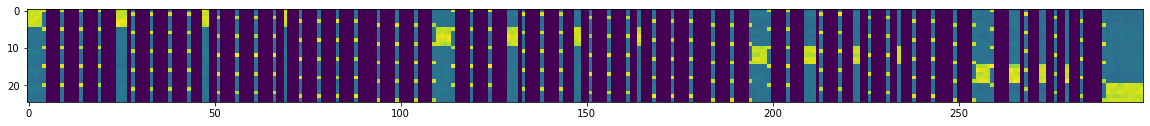

In [31]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

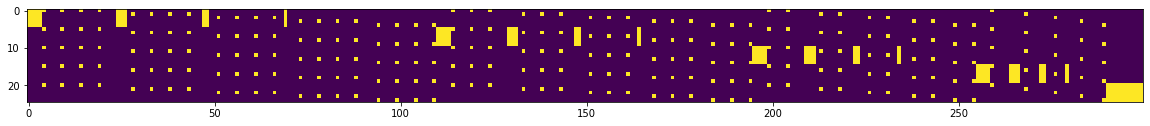

In [32]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

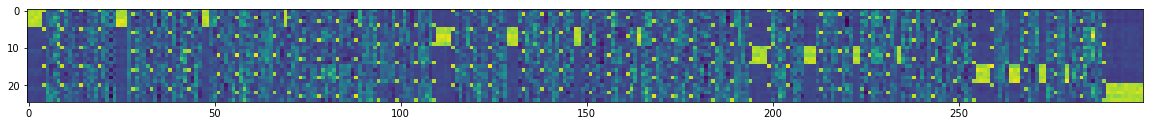

In [33]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

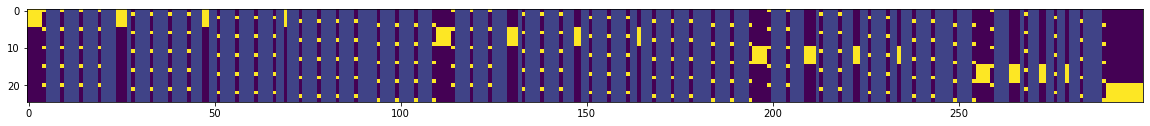

In [34]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])